In [1]:
from bertopic import BERTopic
import numpy as np
import pandas as pd
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import datetime
import nltk
from nltk.corpus import stopwords
import logging
import os
from dotenv import load_dotenv
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import openai
import spacy
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from sklearn.metrics import silhouette_score
import os
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import json

# Auxiliary Functions

In [2]:
def auto_save_figure(fig, figure_name, save_formats=['png'], 
                    width=1000, height=700, scale=2, output_dir="../../outputs/plots"):
    """
    Automatically save any Plotly or Matplotlib figure to disk with multiple formats and timestamp
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The figure to save (supports both Plotly and Matplotlib)
    figure_name : str
        Descriptive name for the figure (will be used in filename)
    save_formats : list
        List of formats to save ['png', 'html', 'pdf', 'svg', 'jpeg']
    width : int
        Width of the saved image
    height : int
        Height of the saved image
    scale : int
        Scale factor for image resolution (higher = better quality)
    output_dir : str
        Directory to save the figures
    
    Returns:
    --------
    dict : Dictionary with saved file paths
    """
    if fig is None:
        print(f"❌ No figure provided for '{figure_name}'")
        return {}
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    # Detect figure type
    is_plotly = hasattr(fig, 'write_image') and hasattr(fig, 'write_html')
    is_matplotlib = hasattr(fig, 'savefig')
    
    if not is_plotly and not is_matplotlib:
        print(f"❌ Unsupported figure type for '{figure_name}': {type(fig)}")
        return {}
    
    for format_type in save_formats:
        # Clean figure name for filename (remove spaces, special chars)
        clean_name = "".join(c for c in figure_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        clean_name = clean_name.replace(' ', '_').lower()
        
        filename = f"{timestamp}_{clean_name}.{format_type}"
        filepath = os.path.join(output_dir, filename)
        
        try:
            if is_plotly:
                # Handle Plotly figures
                if format_type == 'html':
                    fig.write_html(filepath)
                    print(f"📊 Saved {figure_name} as HTML: {filename}")
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    fig.write_image(
                        filepath,
                        width=width,
                        height=height,
                        scale=scale,
                        format=format_type
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
                    
            elif is_matplotlib:
                # Handle Matplotlib figures
                if format_type == 'html':
                    # Convert matplotlib to HTML via mpld3 (if available) or skip
                    try:
                        import mpld3
                        html_str = mpld3.fig_to_html(fig)
                        with open(filepath, 'w') as f:
                            f.write(html_str)
                        print(f"📊 Saved {figure_name} as HTML: {filename}")
                    except ImportError:
                        print(f"⚠️  Skipping HTML for matplotlib figure '{figure_name}' (mpld3 not available)")
                        continue
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    # Set DPI based on scale
                    dpi = 100 * scale
                    fig.savefig(
                        filepath,
                        format=format_type,
                        dpi=dpi,
                        bbox_inches='tight',
                        facecolor='white',
                        edgecolor='none'
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
            
            saved_files[format_type] = os.path.abspath(filepath)
            
        except Exception as e:
            print(f"❌ Error saving {figure_name} as {format_type}: {e}")
    
    if saved_files:
        print(f"✅ Total saved: {len(saved_files)} file(s) for '{figure_name}'")
        print(f"📁 Location: {os.path.abspath(output_dir)}")
        print("-" * 60)
    
    return saved_files

In [3]:
def enhance_bertopic_figure(fig, viz_type):
    """
    Enhance BERTopic figures with specific optimizations for each visualization type
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        The BERTopic figure to enhance
    viz_type : str
        Type of visualization ('topics', 'topics_per_class', 'heatmap', etc.)
    
    Returns:
    --------
    plotly.graph_objects.Figure : Enhanced figure
    """
    if fig is None:
        return fig
        
    try:
        if viz_type == 'topics':
            # Fix intertopic distance map cropping issues
            fig.update_layout(
                # Increase margins to prevent cropping
                margin=dict(l=80, r=80, t=100, b=80),
                # Ensure proper aspect ratio
                width=1200,
                height=900,
                # Add padding to prevent cluster cutoff
                xaxis=dict(
                    range=None,  # Let plotly auto-scale
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                yaxis=dict(
                    range=None,  # Let plotly auto-scale  
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                # Improve title positioning
                title=dict(
                    x=0.5,
                    xanchor='center',
                    y=0.95,
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'topics_per_class':
            # Ensure all topics are visible (not just the first one)
            # Make all traces visible by default
            if hasattr(fig, 'data'):
                for trace in fig.data:
                    trace.visible = True
                    
            # Improve layout for topics per class
            fig.update_layout(
                margin=dict(l=150, r=100, t=120, b=60),  # Increased left margin for longer class names
                width=1200,
                height=800,
                # Ensure legend is visible and functional
                showlegend=True,
                legend=dict(
                    orientation="v",
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                    bgcolor='rgba(255,255,255,0.8)',
                    bordercolor='rgba(0,0,0,0.3)',
                    borderwidth=1
                ),
                # Improve title
                title=dict(
                    x=0.5,
                    xanchor='center',
                    font=dict(size=18)
                ),
                plot_bgcolor='white',
                paper_bgcolor='white'
            )
            
        elif viz_type == 'heatmap':
            # Optimize heatmap layout
            fig.update_layout(
                margin=dict(l=120, r=80, t=100, b=120),
                width=1000,
                height=700
            )
            
        elif viz_type == 'document_datamap':
            # Optimize document datamap
            fig.update_layout(
                margin=dict(l=80, r=80, t=100, b=80),
                width=1200,
                height=900
            )
            
        elif viz_type == 'hierarchy':
            # Optimize hierarchy plot
            fig.update_layout(
                margin=dict(l=100, r=100, t=100, b=100),
                width=1400,
                height=800
            )
            
    except Exception as e:
        print(f"⚠️  Warning: Could not enhance {viz_type} figure: {e}")
        
    return fig

In [4]:
def get_figure_dimensions(fig):
    """
    Safely extract width and height from a Plotly figure
    """
    try:
        # Try to access width and height from layout
        layout = fig.layout if hasattr(fig, 'layout') else None
        if layout:
            width = getattr(layout, 'width', None) or 1000
            height = getattr(layout, 'height', None) or 700
            return width, height
    except:
        pass
    
    # Fallback to defaults
    return 1000, 700

In [5]:
# Enhanced wrapper function for BERTopic visualizations with optimizations
def save_bertopic_figure_enhanced(fig, viz_type, group_name="Female_ADHD", apply_enhancements=True, **kwargs):
    """
    Enhanced function for saving BERTopic visualizations with automatic optimizations
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The BERTopic figure to save
    viz_type : str
        Type of visualization ('topics', 'heatmap', 'hierarchy', 'topics_per_class', etc.)
    group_name : str
        Name of the group being analyzed
    apply_enhancements : bool
        Whether to apply BERTopic-specific enhancements (default: True)
    **kwargs : additional arguments passed to auto_save_figure
    """
    # Apply enhancements if requested and if it's a Plotly figure
    if apply_enhancements and hasattr(fig, 'update_layout'):
        print(f"🔧 Applying {viz_type} specific optimizations...")
        fig = enhance_bertopic_figure(fig, viz_type)
    
    figure_name = f"bertopic_{viz_type}_{group_name}"
    
    # Set default high-quality settings for BERTopic figures
    kwargs.setdefault('save_formats', ['png', 'html'])
    kwargs.setdefault('scale', 2)
    
    # Safely get figure dimensions
    width, height = get_figure_dimensions(fig)
    kwargs.setdefault('width', width)
    kwargs.setdefault('height', height)
    
    return auto_save_figure(fig, figure_name, **kwargs)

In [6]:
def translate_topic_words(topic_model, target_language='en', source_language='pt'):
    """
    Translate topic words from Portuguese to English
    """
    translator = GoogleTranslator(source=source_language, target=target_language)
    
    # Hardcoded translations for specific terms
    hardcoded_translations = {
        'phda': 'adhd',
        'PHDA': 'ADHD',
        'Phda': 'ADHD'
    }
    
    topics_dict = topic_model.get_topics()
    translated_topics = {}
    
    for topic_id, words_scores in topics_dict.items():
        if topic_id == -1:  # Skip noise topic
            continue
            
        # Extract just the words (first element of each tuple)
        words = [word for word, score in words_scores]
        
        # Translate words
        try:
            translated_words = []
            for word in words:
                # Check if we have a hardcoded translation first
                if word in hardcoded_translations:
                    translated = hardcoded_translations[word]
                else:
                    translated = translator.translate(word)
                translated_words.append(translated)
            
            # Keep the same scores but with translated words
            translated_topic = [(translated_words[i], score) for i, (word, score) in enumerate(words_scores)]
            translated_topics[topic_id] = translated_topic
            
        except Exception as e:
            print(f"Error translating topic {topic_id}: {e}")
            # Keep original if translation fails
            translated_topics[topic_id] = words_scores
    
    return translated_topics

In [7]:
def customize_topics_per_class_figure(fig, custom_title=None):
    """
    Customize the topics per class figure with custom title, colors, and class name mapping.
    Adds dashed separators between classes on the y-axis.
    """
    if fig is None:
        return fig

    # Set custom title
    if custom_title:
        fig.update_layout(
            title=dict(
                text=f"<b>{custom_title}</b>",
                x=0.5,
                xanchor='center',
                font=dict(size=18)
            )
        )

    # colors = [
    #     "#e69f00", "#56b4e9", "#009e73", "#fde59", "#d55e00", "#0072b2",
    #     "#ff9896", "#8c52ff", "#af4c0f", "#507736", "#1800ad", "#0097b2",
    #     "#ffbb78", "#98df8a", "#ff5757", "#c5b0d5", "#c49c94", "#f7b6d3",
    #     "#420303", "#a6a6a6", "#cb6ce6", "#00bf63", "#3f5757", "#883c5e",
    #     "#b18164", "#576580",
    # ]
    
    colors = [
        "#e6194b", "#f58231", "#ffe119", "#bfef45", "#3cb44b", "#42d4f4",
        "#4363d8", "#911eb4", "#f032e6", "#a9a9a9", "#800000", "#883c5e",
        "#9a6324", "#808000", "#527564", "#469990", "#0a6161", "#13501b",
        "#000075", "#3D0A55", "#7284A8", "#dcbeff", "#fabed4", "#fdc791",
        "#fffac8", "#aaffc3"
    ]

    try:
        # Update trace colors and ensure all are visible
        for i, trace in enumerate(fig.data):
            color = colors[i % len(colors)]
            trace.update(
                marker=dict(color=color),
                visible=True
            )

        # Add dashed separators between classes
        print("🔍 DEBUG: Analyzing figure structure for class separators...")
        
        # Method 1: Try to get y-axis categories from layout
        y_categories = None
        if hasattr(fig, 'layout') and hasattr(fig.layout, 'yaxis'):
            yaxis = fig.layout.yaxis
            
            # Check different possible locations for y-axis labels
            if hasattr(yaxis, 'categoryarray') and yaxis.categoryarray:
                y_categories = list(yaxis.categoryarray)
                print(f"📋 Found categoryarray: {y_categories}")
            elif hasattr(yaxis, 'ticktext') and yaxis.ticktext:
                y_categories = list(yaxis.ticktext)
                print(f"📋 Found ticktext: {y_categories}")
        
        # Method 2: Extract y-values from traces if categories not found in layout
        if not y_categories:
            print("🔍 Extracting y-values from trace data...")
            y_values_set = set()
            
            for trace in fig.data:
                if hasattr(trace, 'y') and trace.y is not None:
                    if hasattr(trace.y, '__iter__'):
                        y_values_set.update(trace.y)
                    else:
                        y_values_set.add(trace.y)
            
            if y_values_set:
                y_categories = sorted(list(y_values_set))
                print(f"📋 Extracted y-categories from traces: {y_categories}")
        
        # Add dashed separators if we found categories
        if y_categories and len(y_categories) > 1:
            print(f"🔧 Adding dashed separators for {len(y_categories)} categories...")
            
            # Expected class names (in the order they should appear)
            expected_classes = ['Empty Sheet', 'Special Interest', 'Diary Entry', 'Self-Defining Memory']
            
            # Find where each class ends to place separators
            class_boundaries = []
            
            # Group categories by class
            current_class = None
            class_start_idx = 0
            
            for i, category in enumerate(y_categories):
                # Determine which class this category belongs to
                category_class = None
                for class_name in expected_classes:
                    if class_name in str(category):
                        category_class = class_name
                        break
                
                # If we've moved to a new class, mark the boundary
                if current_class is not None and category_class != current_class:
                    # Add separator at the boundary (between classes)
                    class_boundaries.append(i - 0.5)  # Place line between current and previous
                    print(f"  Boundary between '{current_class}' and '{category_class}' at position {i - 0.5}")
                
                current_class = category_class
            
            # Alternative approach: Add separators at regular intervals if class detection fails
            if not class_boundaries:
                print("⚠️  Could not detect class boundaries automatically. Using regular intervals...")
                # Assume 4 classes with roughly equal number of topics each
                n_categories = len(y_categories)
                class_size = n_categories / 4  # 4 expected classes
                
                for i in range(1, 4):  # Add 3 separators for 4 classes
                    boundary_pos = i * class_size - 0.5
                    class_boundaries.append(boundary_pos)
                    print(f"  Regular boundary at position {boundary_pos}")
            
            # Create dashed line shapes
            shapes = []
            for boundary_pos in class_boundaries:
                shapes.append(dict(
                    type="line",
                    xref="paper",  # Reference to paper coordinates (0 to 1)
                    yref="y",      # Reference to y-axis data coordinates
                    x0=0,          # Start at left edge
                    x1=1,          # End at right edge
                    y0=boundary_pos,   # Y position of the line
                    y1=boundary_pos,   # Same Y position (horizontal line)
                    line=dict(
                        color="gray",
                        width=2,
                        dash="dash"
                    ),
                    layer="above"  # Draw on top of the plot
                ))
            
            if shapes:
                fig.update_layout(shapes=shapes)
                print(f"✅ Added {len(shapes)} dashed separators between classes")
            else:
                print("⚠️  No class boundaries detected - no separators added")
        
        else:
            print("⚠️  Could not find y-categories for separator placement")

        # Legend and layout
        if len(fig.data) > 1:
            fig.update_layout(
                showlegend=True,
                legend=dict(
                    orientation="v",
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                    bgcolor='rgba(255,255,255,0.8)',
                    bordercolor='rgba(0,0,0,0.3)',
                    borderwidth=1
                )
            )

        fig.update_layout(
            margin=dict(l=150, r=100, t=120, b=60),
            width=1200,
            height=800,
            plot_bgcolor='white',
            paper_bgcolor='white'
        )

        print("✅ Successfully customized topics per class figure with dashed separators")

    except Exception as e:
        print(f"⚠️  Warning: Could not fully customize figure: {e}")
        import traceback
        print(f"🔍 Detailed error: {traceback.format_exc()}")

    return fig

In [8]:
def visualize_barchart_translated_fixed(topic_model, translated_topics, topics=None, top_k_topics=11, n_words=5, 
                                        custom_labels=True, title="<b>Topic Word Scores</b>", 
                                        width=1600, height=1200):
    """
    Create a bar chart visualization in the exact same style as BERTopic's visualize_barchart
    but with translated words - FIXED VERSION for proper label mapping
    Now displays topics in 2 columns (5 left, 5 right) for better readability
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get topic information and prepare data
    topic_info = topic_model.get_topic_info()
    
    # Select topics to show (excluding outliers/noise topic -1)
    if topics is None:
        # Get top k topics by size (excluding noise topic -1)
        selected_topics = topic_info[topic_info['Topic'] != -1].head(top_k_topics)['Topic'].tolist()
    else:
        # Filter out -1 from provided topics
        selected_topics = [t for t in topics if t != -1]
    
    # Filter selected_topics to only include those that exist in translated_topics
    available_topics = [topic_id for topic_id in selected_topics if topic_id in translated_topics]
    
    print(f"DEBUG: Available topics for plotting: {available_topics}")
    
    # Create subplot titles ONLY for the topics that will actually be plotted
    # The key fix: properly map topic IDs to their position in the topic_info dataframe
    subplot_titles = []
    for topic_id in available_topics:
        if custom_labels and hasattr(topic_model, 'custom_labels_') and topic_model.custom_labels_:
            # Find the topic in topic_info and get its custom label
            topic_row = topic_info[topic_info['Topic'] == topic_id]
            if not topic_row.empty and 'CustomName' in topic_row.columns:
                topic_label = topic_row.iloc[0]['CustomName']
            elif not topic_row.empty and 'Name' in topic_row.columns:
                topic_label = topic_row.iloc[0]['Name']
            else:
                # Fallback: try to get from custom_labels_ array using topic position
                # Find the position of this topic in the topic_info (excluding outliers)
                non_outlier_topics = topic_info[topic_info['Topic'] != -1]
                topic_position = None
                for idx, row in non_outlier_topics.iterrows():
                    if row['Topic'] == topic_id:
                        topic_position = list(non_outlier_topics.index).index(idx)
                        break
                
                if topic_position is not None and topic_position < len(topic_model.custom_labels_):
                    topic_label = topic_model.custom_labels_[topic_position]
                else:
                    topic_label = f"Topic {topic_id}"
        else:
            topic_label = f"Topic {topic_id}"
        
        print(f"DEBUG: Topic {topic_id} -> Label: {topic_label}")
        subplot_titles.append(topic_label)
    
    # Prepare subplot structure - 2 columns layout (5 topics per column)
    n_topics = len(available_topics)
    if n_topics == 0:
        print("No topics available for plotting")
        return None
    
    # Calculate rows and columns for 2-column layout
    n_cols = 2
    n_rows = (n_topics + 1) // 2  # Ceiling division to get enough rows
    
    # Pad subplot_titles to match the grid if needed
    while len(subplot_titles) < n_rows * n_cols:
        subplot_titles.append("")
        
    fig = make_subplots(
        rows=n_rows, 
        cols=n_cols,
        shared_xaxes=False,
        horizontal_spacing=0.12,  # Space between columns
        vertical_spacing=0.15,   # Space between rows
        subplot_titles=subplot_titles[:n_topics]  # Only use titles for actual topics
    )
    
    # Color scheme similar to BERTopic
    colors = [
        "#e6194b", "#f58231", "#ffe119", "#bfef45", "#3cb44b", "#42d4f4",
        "#4363d8", "#911eb4", "#f032e6", "#a9a9a9", "#800000", "#883c5e",
        "#9a6324", "#808000", "#527564", "#469990", "#0a6161", "#13501b",
        "#000075", "#3D0A55", "#7284A8", "#dcbeff", "#fabed4", "#fdc791",
        "#fffac8", "#aaffc3"
    ]
    
    # Process each topic that will actually be plotted
    for i, topic_id in enumerate(available_topics):
        # Calculate row and column position for 2-column grid
        row = (i // 2) + 1  # Row number (1-indexed)
        col = (i % 2) + 1   # Column number (1-indexed)
        
        # Get translated words and scores
        words_scores = translated_topics[topic_id][:n_words]
        words = [word for word, score in words_scores]
        scores = [score for word, score in words_scores]
        
        # Reverse order for proper display (highest scores at top)
        words = words[::-1]
        scores = scores[::-1]
        
        # Create horizontal bar trace
        trace = go.Bar(
            y=words,
            x=scores,
            orientation='h',
            marker=dict(
                color=colors[i % len(colors)],
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            text=[f"<b>{score:.3f}</b>" for score in scores],  # Bold text for better visibility
            textposition='auto',  # Changed from 'outside' to 'auto' to prevent cutoff
            textfont=dict(size=11, color='white'),  # White text for better contrast
            hovertemplate='<b>%{y}</b><br>Score: %{x:.3f}<extra></extra>',
            showlegend=False,
            name=f"Topic {topic_id}"
        )
        
        fig.add_trace(trace, row=row, col=col)
    
    # Update layout to match BERTopic style with better spacing for 2-column layout
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor="center",
            font=dict(size=18, color="black")  # Larger title font
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color="black", size=12),  # Larger general font
        margin=dict(l=40, r=40, t=80, b=40)  # Increased margins to prevent text cutoff
    )
    
    # Update axes for each subplot in the 2-column grid
    for i in range(n_topics):
        row = (i // 2) + 1
        col = (i % 2) + 1
        
        # X-axis
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(0,0,0,0.1)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(0,0,0,0.3)',
            showline=True,
            linewidth=1,
            linecolor='black',
            tickfont=dict(size=11),  # Readable tick font
            automargin=True,  # Automatically adjust margins to fit text
            row=row, col=col
        )
        
        # Y-axis
        fig.update_yaxes(
            showgrid=False,
            showline=True,
            linewidth=1,
            linecolor='black',
            tickfont=dict(size=11),  # Readable tick font
            row=row, col=col
        )
    
    # Update annotation style for subplot titles (larger font for readability)
    fig.update_annotations(font_size=14, font_color="black")
    
    return fig

In [9]:
def save_topic_texts(topic_model, texts, output_folder, group_name, min_texts_per_topic=2):
    """
    Save the texts belonging to each topic to separate .txt files
    
    Parameters:
    -----------
    topic_model : BERTopic
        The trained BERTopic model
    texts : list
        List of original texts used for topic modeling
    output_folder : str
        Directory to save the topic text files
    group_name : str
        Name of the group being analyzed (for filename prefix)
    min_texts_per_topic : int
        Minimum number of texts required to create a file for a topic
    
    Returns:
    --------
    dict : Dictionary with topic_id as key and number of texts as value
    """
    import os
    
    # Get topic assignments for each document
    if len(texts) != len(topic_model.topics_):
        print("⚠️  Warning: Text length doesn't match topic assignments length")
        print(f"Texts: {len(texts)}, Topics: {len(topic_model.topics_)}")
        print("Using the minimum length to avoid errors")
        min_len = min(len(texts), len(topic_model.topics_))
        texts = texts[:min_len]
        topics = topic_model.topics_[:min_len]
    else:
        topics = topic_model.topics_
    
    # Get topic info for labels
    topic_info = topic_model.get_topic_info()
    
    # Create subdirectory for topic texts
    topic_texts_dir = os.path.join(output_folder, "topic_texts")
    os.makedirs(topic_texts_dir, exist_ok=True)
    
    # Group texts by topic
    topic_texts_dict = {}
    for text, topic_id in zip(texts, topics):
        if topic_id not in topic_texts_dict:
            topic_texts_dict[topic_id] = []
        topic_texts_dict[topic_id].append(text)
    
    # Save texts for each topic
    topic_counts = {}
    saved_topics = 0
    skipped_topics = 0
    
    for topic_id, topic_texts in topic_texts_dict.items():
        topic_counts[topic_id] = len(topic_texts)
        
        # Skip outlier topic (-1) and topics with too few texts
        if topic_id == -1:
            print(f"📝 Skipping outlier topic {topic_id} with {len(topic_texts)} texts")
            skipped_topics += 1
            continue
            
        if len(topic_texts) < min_texts_per_topic:
            print(f"📝 Skipping topic {topic_id} with only {len(topic_texts)} texts (minimum: {min_texts_per_topic})")
            skipped_topics += 1
            continue
        
        # Get topic label from topic_info
        topic_row = topic_info[topic_info['Topic'] == topic_id]
        if not topic_row.empty:
            if 'CustomName' in topic_row.columns and pd.notna(topic_row.iloc[0]['CustomName']):
                topic_label = topic_row.iloc[0]['CustomName']
            elif 'Name' in topic_row.columns and pd.notna(topic_row.iloc[0]['Name']):
                topic_label = topic_row.iloc[0]['Name']
            else:
                topic_label = f"Topic_{topic_id}"
        else:
            topic_label = f"Topic_{topic_id}"
        
        # Clean topic label for filename
        clean_label = "".join(c for c in topic_label if c.isalnum() or c in (' ', '-', '_')).rstrip()
        clean_label = clean_label.replace(' ', '_').lower()
        
        # Create filename
        filename = f"{group_name}_topic_{topic_id}_{clean_label}.txt"
        filepath = os.path.join(topic_texts_dir, filename)
        
        # Write texts to file
        try:
            with open(filepath, 'w', encoding='utf-8') as f:
                f.write(f"Topic {topic_id}: {topic_label}\n")
                f.write(f"Number of texts: {len(topic_texts)}\n")
                f.write("=" * 60 + "\n\n")
                
                for i, text in enumerate(topic_texts, 1):
                    f.write(f"Text {i}:\n")
                    f.write(f"{text}\n")
                    f.write("-" * 40 + "\n\n")
            
            print(f"💾 Saved {len(topic_texts)} texts for Topic {topic_id} ({topic_label}) to {filename}")
            saved_topics += 1
            
        except Exception as e:
            print(f"❌ Error saving Topic {topic_id}: {e}")
    
    # Save summary
    summary_file = os.path.join(topic_texts_dir, f"{group_name}_topic_texts_summary.txt")
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write(f"Topic Texts Summary for {group_name}\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Total topics processed: {len(topic_texts_dict)}\n")
        f.write(f"Topics saved: {saved_topics}\n")
        f.write(f"Topics skipped: {skipped_topics}\n")
        f.write(f"Minimum texts per topic: {min_texts_per_topic}\n\n")
        
        f.write("Topic Distribution:\n")
        f.write("-" * 30 + "\n")
        for topic_id, count in sorted(topic_counts.items()):
            if topic_id == -1:
                f.write(f"Topic {topic_id} (Outliers): {count} texts\n")
            else:
                topic_row = topic_info[topic_info['Topic'] == topic_id]
                if not topic_row.empty:
                    if 'CustomName' in topic_row.columns and pd.notna(topic_row.iloc[0]['CustomName']):
                        label = topic_row.iloc[0]['CustomName']
                    elif 'Name' in topic_row.columns and pd.notna(topic_row.iloc[0]['Name']):
                        label = topic_row.iloc[0]['Name']
                    else:
                        label = f"Topic_{topic_id}"
                else:
                    label = f"Topic_{topic_id}"
                
                status = "SAVED" if count >= min_texts_per_topic else "SKIPPED"
                f.write(f"Topic {topic_id} ({label}): {count} texts [{status}]\n")
    
    print(f"\n✅ Topic texts extraction completed!")
    print(f"📊 Saved {saved_topics} topic files, skipped {skipped_topics} topics")
    print(f"📁 Files saved to: {topic_texts_dir}")
    print(f"📄 Summary saved to: {summary_file}")
    
    return topic_counts

In [10]:
def get_silhouette_score(topic_model, embeddings, use_reduced_embeddings=False):
    """
    Calculate silhouette score for topic clustering quality assessment - CORRECTED VERSION
    
    Parameters:
    -----------
    topic_model : BERTopic
        The trained BERTopic model
    embeddings : np.array
        Original document embeddings used for training
    use_reduced_embeddings : bool
        Whether to use dimensionality-reduced embeddings (default: False, uses original)
        
    Returns:
    --------
    dict : Dictionary with silhouette scores and diagnostic info
    """
    from sklearn.metrics import silhouette_score
    from sklearn.decomposition import PCA
    import numpy as np
    
    # Get document-topic assignments
    document_topics = topic_model.topics_
    
    # Validate inputs
    if len(embeddings) != len(document_topics):
        print(f"Warning: Embedding length ({len(embeddings)}) != topic assignments length ({len(document_topics)})")
        min_len = min(len(embeddings), len(document_topics))
        embeddings = embeddings[:min_len]
        document_topics = document_topics[:min_len]
    
    # Filter out outlier/noise topics (-1)
    valid_indices = [i for i, topic in enumerate(document_topics) if topic != -1]
    
    # Diagnostic information
    total_docs = len(document_topics)
    outlier_docs = sum(1 for t in document_topics if t == -1)
    valid_docs = len(valid_indices)
    unique_topics = list(set([topic for topic in document_topics if topic != -1]))
    
    print(f"📊 SILHOUETTE SCORE DIAGNOSTICS:")
    print(f"  Total documents: {total_docs}")
    print(f"  Outlier documents (-1 topic): {outlier_docs} ({outlier_docs/total_docs*100:.1f}%)")
    print(f"  Valid documents: {valid_docs} ({valid_docs/total_docs*100:.1f}%)")
    print(f"  Number of unique topics: {len(unique_topics)}")
    
    # Check if we have enough valid documents and topics
    if valid_docs < 2:
        print("❌ Error: Not enough valid documents (non-outlier) for silhouette score calculation")
        return {"silhouette_score": 0.0, "error": "insufficient_valid_docs"}
    
    if len(unique_topics) < 2:
        print("❌ Error: Need at least 2 topics for silhouette score calculation")
        return {"silhouette_score": 0.0, "error": "insufficient_topics"}
    
    # Topic distribution analysis
    from collections import Counter
    topic_counts = Counter([document_topics[i] for i in valid_indices])
    print(f"  Topic distribution: {dict(topic_counts)}")
    
    # Check for severely imbalanced topics
    min_topic_size = min(topic_counts.values())
    max_topic_size = max(topic_counts.values())
    if min_topic_size == 1:
        print(f"⚠️  Warning: Some topics have only 1 document - this affects silhouette score quality")
    
    # Prepare embeddings and labels
    X_valid = embeddings[valid_indices]
    labels_valid = [document_topics[i] for i in valid_indices]
    
    # Calculate silhouette score using ORIGINAL embeddings (not UMAP!)
    try:
        if use_reduced_embeddings and X_valid.shape[1] > 50:
            # Optional: Use PCA for dimensionality reduction (much better than UMAP for distances)
            print(f"🔄 Using PCA to reduce dimensions from {X_valid.shape[1]} to 50...")
            pca = PCA(n_components=50, random_state=42)
            X_reduced = pca.fit_transform(X_valid)
            explained_variance = pca.explained_variance_ratio_.sum()
            print(f"  PCA explained variance: {explained_variance:.3f}")
            score = silhouette_score(X_reduced, labels_valid)
            method = f"PCA-reduced (50D, {explained_variance:.3f} variance)"
        else:
            # Use original high-dimensional embeddings (RECOMMENDED)
            print(f"🔄 Using original embeddings ({X_valid.shape[1]}D)...")
            score = silhouette_score(X_valid, labels_valid)
            method = f"Original embeddings ({X_valid.shape[1]}D)"
        
        print(f"✅ Silhouette score: {score:.4f} (method: {method})")
        
        # Interpret the score
        if score > 0.5:
            interpretation = "Excellent clustering"
        elif score > 0.3:
            interpretation = "Good clustering"
        elif score > 0.1:
            interpretation = "Weak but acceptable clustering"
        elif score > 0:
            interpretation = "Poor clustering (overlapping clusters)"
        else:
            interpretation = "Very poor clustering (worse than random)"
        
        print(f"📈 Interpretation: {interpretation}")
        
        return {
            "silhouette_score": float(score),
            "method": method,
            "interpretation": interpretation,
            "total_docs": total_docs,
            "valid_docs": valid_docs,
            "outlier_docs": outlier_docs,
            "num_topics": len(unique_topics),
            "topic_distribution": dict(topic_counts),
            "error": None
        }
        
    except Exception as e:
        print(f"❌ Error calculating silhouette score: {e}")
        return {"silhouette_score": 0.0, "error": str(e)}

In [11]:
def calculate_topic_coherence_umass(topic_model, texts, vectorizer_model=None, top_k_words=10):
    """
    UMass topic coherence (Mimno et al.): average over ordered word pairs (j<i) of
        log((D(w_i, w_j) + 1) / D(w_j)),
    where D(.) counts documents containing the term(s). Scores are typically negative;
    higher (closer to 0) is better.
    """
    import numpy as np
    from scipy import sparse

    # Prefer the model's vectorizer to keep vocab/preprocessing aligned
    if vectorizer_model is None and hasattr(topic_model, "vectorizer_model") and topic_model.vectorizer_model is not None:
        print("Vectorizer available!")
        vectorizer_model = topic_model.vectorizer_model

    # Fallback if the model has none
    if vectorizer_model is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer_model = CountVectorizer(
            ngram_range=(1, 2),
            lowercase=True,
            token_pattern=r"(?u)\b\w\w+\b"
        )

    # Use transform if already fitted to preserve vocab; else fit
    if hasattr(vectorizer_model, "vocabulary_") and vectorizer_model.vocabulary_:
        X = vectorizer_model.transform(texts)
        feature_names = np.array(sorted(vectorizer_model.vocabulary_, key=vectorizer_model.vocabulary_.get))
    else:
        X = vectorizer_model.fit_transform(texts)
        feature_names = vectorizer_model.get_feature_names_out()

    # Boolean presence matrix (sparse)
    X = X.astype(bool).astype(int)  # keeps it sparse CSR

    # Fast doc freq helper on sparse columns
    def df(col_idx):
        return X[:, col_idx].sum()

    # Word -> column index
    word_to_idx = {w: i for i, w in enumerate(feature_names)}

    topics = topic_model.get_topics()
    topic_coherences = {}

    for topic_id, word_scores in topics.items():
        if topic_id == -1:
            continue
        words = [w for (w, _) in word_scores[:top_k_words]]

        pair_scores = []
        for i in range(1, len(words)):
            wi = words[i]
            if wi not in word_to_idx:
                continue
            i_idx = word_to_idx[wi]
            for j in range(i):
                wj = words[j]
                if wj not in word_to_idx:
                    continue
                j_idx = word_to_idx[wj]

                Dj = df(j_idx)
                if Dj == 0:
                    continue  # undefined conditioning; skip

                # co-doc frequency via elementwise multiply (still sparse)
                Dij = X[:, i_idx].multiply(X[:, j_idx]).sum()

                # UMass with +1 smoothing on the numerator
                pair_scores.append(np.log((Dij + 1.0) / Dj))

        topic_coherences[topic_id] = float(np.mean(pair_scores)) if pair_scores else float("nan")

    # Average across non-NaN topics
    valid = [v for v in topic_coherences.values() if np.isfinite(v)]
    avg = float(np.mean(valid)) if valid else float("nan")

    return {
        "topic_coherences": topic_coherences,
        "average_coherence": avg,
        "method": "UMass",
        "top_k_words": top_k_words,
        "description": "UMass coherence using document co-occurrence with +1 smoothing; higher (less negative) is better."
    }


In [12]:
def load_bert_model(path):
    return BERTopic.load(path, embedding_model=SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"))

In [13]:
def get_corresponding_df(df, group_name):
    if group_name == "Female_ADHD":
        topic_df = df[df["group"] == "Female_ADHD"]
        print("Female_ADHD")
    elif group_name == "Female_noADHD":
        topic_df = df[df["group"] == "Female_noADHD"]
        print("Female_noADHD")
    elif group_name == "ADHD":
        topic_df = df[df["group"].isin(["Male_ADHD", "Female_ADHD"])]
        print("ADHD")
    elif group_name == "noADHD":
        topic_df = df[df["group"].isin(["Male_noADHD", "Female_noADHD"])]
        print("noADHD")
    return topic_df

# Preload

In [14]:
topic_df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl")
topic_df

,datetime,sex,adhd_diagnosis,age,education,occupation,dialect,forgetting_objects,forgetting_responsabilities,emotion_management,...,need_fast_talk_interest,need_fast_talk_information,speaking_before_thinking,something_to_add,something_to_add_timid,something_to_add_impulsive,question,response,response_embedding,group
1,2025-03-30T16:29:47+02:00,Feminino,Não tenho,22,Licenciatura,Estudante,Português de Portugal,3,3,4,...,1,1,3,4,4,2,special_interest,"Adoro cozinhar, porque sinto que é a forma ide...","[-0.0066892994, -0.008711162, 0.020823173, -0....",Female_noADHD
3,2025-03-31T12:08:00+02:00,Feminino,Não tenho,23,Mestrado,Trabalhador-estudante,Português de Portugal,2,1,4,...,1,1,4,4,4,2,special_interest,Gosto de ver séries porque relatam relações sa...,"[0.011201557, -0.016555935, 0.05544479, 0.0285...",Female_noADHD
8,2025-03-31T12:55:43+02:00,Feminino,Não tenho,19,Licenciatura,Estudante,Português de Portugal,3,2,2,...,4,4,2,4,3,3,special_interest,Campos de ferias. Temos que criar o campo todo...,"[-0.010825635, -0.023888972, -0.013832389, -0....",Female_noADHD
14,2025-03-31T13:54:40+02:00,Feminino,Não tenho,25,Mestrado,Trabalhador,Português de Portugal,4,3,4,...,2,3,3,5,4,4,special_interest,"Taylor Swift, amo o seu liricismo e a maneira ...","[-0.029966783, -0.030345816, 0.014844258, 0.01...",Female_noADHD
15,2025-03-31T13:58:15+02:00,Feminino,Suspeito que tenho,25,Licenciatura,Trabalhador,Português de Portugal,4,2,5,...,2,2,3,5,5,3,special_interest,Historia da arte \nÉ só tão interessante. Para...,"[-0.026616443, -0.021927392, 0.014119624, 0.01...",Female_noADHD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2025-06-07T16:05:17+02:00,Feminino,"Sim, diagnosticado",51,Mestrado,Trabalhador-estudante,Português de Portugal,4,2,5,...,3,2,4,4,5,5,empty_sheet,"O ponto em que sociedade se está a tornar,: eg...","[-0.019272415, -0.014781286, 0.036758002, 0.00...",Female_ADHD
296,2025-06-07T17:23:10+02:00,Feminino,"Sim, diagnosticado",36,Pós-Graduação,Estudante,Português de Portugal,5,3,3,...,2,3,3,4,3,3,empty_sheet,Gostava que não dissessem : toda a gente tem p...,"[-0.05752369, 0.0008796515, -0.011525935, -0.0...",Female_ADHD
307,2025-06-10T16:58:08+02:00,Feminino,"Sim, diagnosticado",19,Ensino secundário,Trabalhador-estudante,Português de Portugal,4,2,4,...,4,4,4,5,4,4,empty_sheet,Não sei explicar o que se anda a passar comigo...,"[-0.026584908, -0.011627352, 0.029701553, -0.0...",Female_ADHD
308,2025-06-10T17:45:28+02:00,Masculino,"Sim, diagnosticado",19,Ensino secundário,Estudante,Português de Portugal,2,3,4,...,1,1,3,4,2,2,empty_sheet,"De momento, na minha cabeça, só rumino sobre o...","[-0.015350613, -0.020685123, 0.0079341745, -0....",Male_ADHD


In [15]:
def preliminary_steps(group_name, folder):
    print(f"Running preliminary steps for group: {group_name}, folder: {folder}")
    df_group = get_corresponding_df(topic_df, group_name)
    path = f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/{folder}/"
    output_folder = f"../../outputs/bertopic_final/{group_name}/{folder}/"
    os.makedirs(output_folder, exist_ok=True)
    topic_model = load_bert_model(path)
    return df_group, topic_model, output_folder

In [16]:
def check_hierarchy(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    
    # Generate and save hierarchical topics (this usually works fine)
    try:
        print("🔄 Generating hierarchical topics...")
        hierarchical_topics = topic_model.hierarchical_topics(texts)
        print("✅ Hierarchical topics generated successfully")
        
        # Visualize hierarchy (this also usually works)
        try:
            print("🔄 Creating hierarchy visualization...")
            fig_hierarchy = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)
            save_bertopic_figure_enhanced(fig_hierarchy, 'hierarchy', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            display(fig_hierarchy)
            print("✅ Hierarchy visualization saved")
        except Exception as e:
            print(f"⚠️  Warning: Could not create hierarchy visualization: {e}")
            
    except Exception as e:
        print(f"⚠️  Warning: Could not generate hierarchical topics: {e}")
    
    # Get and save topic info (this always works)
    try:
        topic_info = topic_model.get_topic_info()
        topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)
        
        num_unique_topics = topic_info['Topic'].nunique()
        num_real_topics = len(topic_info[topic_info['Topic'] != -1])  # Exclude outlier topic
        
        print(f"📊 Number of unique topics: {num_unique_topics}")
        print(f"📊 Number of real topics (excluding outliers): {num_real_topics}")
        
        # Save topic summary
        with open(f"{output_folder}/topic_summary.txt", "w") as f:
            f.write(f"Total unique topics: {num_unique_topics}\n")
            f.write(f"Real topics (excluding outliers): {num_real_topics}\n")
            f.write(f"Total documents: {len(texts)}\n")
            f.write(f"Documents per topic (avg): {len(texts) / max(num_real_topics, 1):.2f}\n")
            
    except Exception as e:
        print(f"❌ Error getting topic info: {e}")
        return topic_model
    
    # Try to create topic visualization with enhanced error handling
    if num_real_topics <= 3:
        print("⚠️  Cannot create topic visualization: Need at least 3 real topics")
        print("💡 This model has too few distinct topics for meaningful visualization")
        
        # Save a note about why visualization was skipped
        with open(f"{output_folder}/visualization_notes.txt", "w") as f:
            f.write(f"Topic visualization skipped: Only {num_real_topics} real topics found\n")
            f.write("Minimum 2 topics required for UMAP dimensionality reduction\n")
            
    elif num_real_topics <= 4:
        print("⚠️  Very few topics detected. Attempting visualization with fallback options...")
        
        # Try with different UMAP parameters for small datasets
        try:
            print("🔄 Attempting topic visualization with adjusted parameters...")
            
            # Create a custom UMAP with parameters suitable for small datasets
            from umap import UMAP
            
            # Override the model's UMAP temporarily with safer parameters
            original_umap = topic_model.umap_model
            
            # Use parameters that work better with few topics
            safe_umap = UMAP(
                n_neighbors=min(2, num_real_topics),  # Very small n_neighbors
                n_components=2,
                metric="cosine",
                random_state=42,
                min_dist=0.1,
                spread=1.0
            )
            
            topic_model.umap_model = safe_umap
            
            # Try the visualization
            fig_topics = topic_model.visualize_topics(custom_labels=True)
            save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            display(fig_topics)
            print("✅ Topic visualization created with adjusted parameters")
            
            # Restore original UMAP
            topic_model.umap_model = original_umap
            
        except (TypeError, ValueError) as e:
            if "k >= N" in str(e) or "zero-size array" in str(e):
                print("⚠️  UMAP spectral initialization failed due to insufficient data")
                print("💡 This is expected with very few topics - the model is still valid")
                
                # Save detailed error info
                with open(f"{output_folder}/visualization_error.txt", "w") as f:
                    f.write(f"Visualization failed due to insufficient topic diversity\n")
                    f.write(f"Error: {str(e)}\n")
                    f.write(f"Real topics: {num_real_topics}\n")
                    f.write(f"This is a known limitation when fewer than 5-6 topics exist\n")
                    
            else:
                print(f"❌ Unexpected error in topic visualization: {e}")
                
        except Exception as e:
            print(f"❌ Other error in topic visualization: {e}")
            
    else:
        # Normal case: enough topics for standard visualization
        try:
            print("🔄 Creating standard topic visualization...")
            fig_topics = topic_model.visualize_topics(custom_labels=True)
            save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            display(fig_topics)
            print("✅ Topic visualization created successfully")
        except Exception as e:
            print(f"❌ Error in standard topic visualization: {e}")
    
    return topic_model

In [17]:
def run_bertopic_evals(topic_model, df_group, output_folder):
    embeddings = np.vstack(df_group["response_embedding"])
    texts = df_group["response"].tolist()
    
    # SILHOUETTE SCORE
    silhouette_results = get_silhouette_score(topic_model, embeddings, use_reduced_embeddings=False)
    silhouette_score_value = silhouette_results.get('silhouette_score', 0.0)
    print(f"Silhouette Score: {silhouette_score_value:.4f}")
    
    with open(f"{output_folder}/silhouette_detailed.json", "w") as f:
        if isinstance(silhouette_results, dict):
            json.dump(silhouette_results, f, indent=2)
        else:
            json.dump({"silhouette_score": float(silhouette_results), "note": "unexpected_return_type"}, f, indent=2)
    
    with open(f"{output_folder}/silhouette_score.txt", "w") as f:
        f.write(f"Silhouette Score: {silhouette_score_value:.4f}\n")
        if isinstance(silhouette_results, dict):
            f.write(f"Method: {silhouette_results.get('method', 'Unknown')}\n")
            f.write(f"Interpretation: {silhouette_results.get('interpretation', 'Unknown')}\n")
            f.write(f"Valid documents: {silhouette_results.get('valid_docs', 0)}/{silhouette_results.get('total_docs', 0)}\n")
            f.write(f"Number of topics: {silhouette_results.get('num_topics', 0)}\n")
            if silhouette_results.get('error'):
                f.write(f"Error: {silhouette_results.get('error')}\n")
    
    # COHERENCE SCORE - Updated to use UMass
    print("Calculating topic coherence using UMass metric...")
    coherence_results = calculate_topic_coherence_umass(topic_model, texts, top_k_words=10)
    avg_coherence = coherence_results['average_coherence']
    topic_coherences = coherence_results['topic_coherences']
    
    print(f"Average Topic Coherence (UMass): {avg_coherence:.4f}")
    print("Individual Topic Coherences:")
    for topic_id, coherence in topic_coherences.items():
        print(f"  Topic {topic_id}: {coherence:.4f}")
    
    # Save coherence results
    with open(f"{output_folder}/coherence_score.txt", "w") as f:
        f.write(f"Average Coherence (UMass): {avg_coherence}\n")
        f.write("Individual Topic Coherences:\n")
        for topic_id, coherence in topic_coherences.items():
            f.write(f"Topic {topic_id}: {coherence}\n")
    
    # Save detailed coherence results as JSON for further analysis
    with open(f"{output_folder}/coherence_detailed.json", "w") as f:
        json.dump(coherence_results, f, indent=2)
    
    print(f"Coherence results saved to {output_folder}")
    print("=" * 60)

In [18]:
def run_bertopic_viz(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    print(f"Number of texts: {len(texts)}")
    print(f"Number of topics: {len(topic_model.topics_)}")
    
    # Check topic distribution before attempting datamap
    topic_info = topic_model.get_topic_info()
    real_topics = topic_info[topic_info['Topic'] != -1]
    print(f"Number of real topics (excluding outliers): {len(real_topics)}")
    
    if len(texts) != len(topic_model.topics_):
        print("Length mismatch detected. The model topics were from different training data.")
        print("Using topic info instead of document info.")
        display(topic_model.get_topic_info())
    else:
        document_info = topic_model.get_document_info(texts)
        document_info.to_csv(f"{output_folder}/document_info.csv", index=False)
        display(document_info)
    print("=" * 60)
        
    fig_heatmap = topic_model.visualize_heatmap(custom_labels=True)
    save_bertopic_figure_enhanced(fig_heatmap, 'heatmap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_heatmap)
    
    classes = df_group["question"].tolist()
    classes = ['Empty Sheet' if x == 'empty_sheet' 
               else 'Special Interest' if x == 'special_interest'
               else 'Diary Entry' if x == 'diary_entry'
               else 'Self-Defining Memory' if x == 'selfdefining_memory'
               else x for x in classes]
    topics_per_class = topic_model.topics_per_class(texts, classes=classes)
    fig_topics_per_class = topic_model.visualize_topics_per_class(topics_per_class, custom_labels=True, top_n_topics=30)
    
    fig_topics_per_class = customize_topics_per_class_figure(
        fig_topics_per_class, 
        custom_title="Distribution of Topic Documents per Open-Ended Questions"
    )
    
    save_bertopic_figure_enhanced(fig_topics_per_class, 'topics_per_class', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_topics_per_class)

    # Check if we have enough valid topics for datamap visualization
    if len(real_topics) < 2:
        print(f"⚠️  Skipping document datamap: Only {len(real_topics)} real topics found (minimum 2 required)")
        with open(f"{output_folder}/datamap_skipped.txt", "w") as f:
            f.write(f"Document datamap skipped: Only {len(real_topics)} real topics found\n")
            f.write("Minimum 2 real topics required for meaningful datamap visualization\n")
    else:
        try:
            print("🔄 Creating document datamap...")
            embeddings = np.vstack(df_group["response_embedding"])
            fig_document_datamap = topic_model.visualize_document_datamap(texts, embeddings=embeddings, custom_labels=True)
            save_bertopic_figure_enhanced(fig_document_datamap, 'document_datamap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            display(fig_document_datamap)
            print("✅ Document datamap created successfully")
        except ValueError as e:
            if "array of sample points is empty" in str(e):
                print("⚠️  Skipping document datamap: Insufficient valid data points for visualization")
                print("💡 This typically happens when most documents are classified as outliers")
                with open(f"{output_folder}/datamap_error.txt", "w") as f:
                    f.write(f"Document datamap failed: {str(e)}\n")
                    f.write("This typically indicates insufficient topic diversity or too many outliers\n")
            else:
                print(f"❌ Unexpected error in document datamap: {e}")
                raise e
        except Exception as e:
            print(f"❌ Error creating document datamap: {e}")

    # Get translated topics
    print("Translating topic words to English...")
    translated_topics = translate_topic_words(topic_model)

    # Save translated topics
    print("\nTranslated Topics (Portuguese → English):")
    print("="*60)
    for topic_id, words_scores in translated_topics.items():
        words = [word for word, score in words_scores[:5]]  # Top 5 words
        print(f"Topic {topic_id}: {', '.join(words)}")
    print("="*60)

    fig_bertopic_style_fixed = visualize_barchart_translated_fixed(
        topic_model, 
        translated_topics, 
        top_k_topics=10,  # Changed to 10 topics (5 per column)
        n_words=5,
        custom_labels=True,
        width=1600,       # Larger width for 2-column layout
        height=1200       # Larger height for better readability
    )
        
    if fig_bertopic_style_fixed:
        save_bertopic_figure_enhanced(fig_bertopic_style_fixed, 'translated_barchart', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
        display(fig_bertopic_style_fixed)
    else:
        print("No valid topics to display")
    
    # Save topic texts to separate files
    print("\n" + "="*60)
    print("💾 Saving topic texts to individual files...")
    topic_counts = save_topic_texts(topic_model, texts, output_folder, group_name, min_texts_per_topic=2)
    print("="*60)

In [19]:
def process_group(group_name, folder):
    print("=" * 60)
    print(f"Found folder: {folder}")
    print("=" * 60)
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    if group_name == "noADHD":
        chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
        chatgpt_topic_labels[13] = "Immersive Fantasy and Anime Interests"
        topic_model.set_topic_labels(chatgpt_topic_labels)
    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)

# Female ADHD

In [20]:
group_name = "Female_ADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/", name))]
folder = folders[0] if folders else None
folder

'Female_ADHD_2_reduced_8_20250825_011741'

Found folder: Female_ADHD_2_reduced_8_20250825_011741
Running preliminary steps for group: Female_ADHD, folder: Female_ADHD_2_reduced_8_20250825_011741
Female_ADHD
🔄 Generating hierarchical topics...


100%|██████████| 7/7 [00:00<00:00, 580.03it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250829_231755_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250829_231755_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_ADHD/Female_ADHD_2_reduced_8_20250825_011741
------------------------------------------------------------


✅ Hierarchy visualization saved
📊 Number of unique topics: 9
📊 Number of real topics (excluding outliers): 8
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250829_231803_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250829_231803_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_ADHD/Female_ADHD_2_reduced_8_20250825_011741
------------------------------------------------------------


✅ Topic visualization created successfully
📊 SILHOUETTE SCORE DIAGNOSTICS:
  Total documents: 65
  Outlier documents (-1 topic): 6 (9.2%)
  Valid documents: 59 (90.8%)
  Number of unique topics: 8
  Topic distribution: {5: 3, 6: 3, 0: 15, 4: 5, 7: 3, 2: 11, 1: 13, 3: 6}
🔄 Using original embeddings (1536D)...
✅ Silhouette score: 0.0523 (method: Original embeddings (1536D))
📈 Interpretation: Poor clustering (overlapping clusters)
Silhouette Score: 0.0523
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -0.7402
Individual Topic Coherences:
  Topic 0: -0.8185
  Topic 1: -0.9933
  Topic 2: -1.1385
  Topic 3: -0.9192
  Topic 4: -0.5082
  Topic 5: -0.5718
  Topic 6: -0.1078
  Topic 7: -0.8642
Coherence results saved to ../../outputs/bertopic_final/Female_ADHD/Female_ADHD_2_reduced_8_20250825_011741/
Number of texts: 65
Number of topics: 65
Number of real topics (excluding outliers): 8


,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Pedras, necrópoles, minerais, música, cinema, ...",5,5_mundo_tão_sei explicar_ideia,Fantasy Worlds and Creativity,"[mundo, tão, sei explicar, ideia, explicar, mu...","[especial, interesse especial, criar, vários, ...",[Fantasy Worlds and Creativity],"[sei explicar, explicar, mundo acho, vários, p...","[mundo, ideia, longo, música, difícil, especia...",NaN,mundo - tão - sei explicar - ideia - explicar ...,False
1,Um dos meus interesses especiais é skincare co...,-1,-1_comigo_amigos_falar_sempre,Outlier Topic,"[comigo, amigos, falar, sempre, pessoas, nunca...","[tornei, comigo mesma, mim, comigo, passei, cé...",[Personal Identity and Social Relationships],"[amigos, sempre, nunca, vida, mim, ano, social...","[comigo, amigos, pessoas, vida, dia, tanto, an...",NaN,comigo - amigos - falar - sempre - pessoas - n...,False
2,Pergunta difícil porque tenho vários e eles vã...,5,5_mundo_tão_sei explicar_ideia,Fantasy Worlds and Creativity,"[mundo, tão, sei explicar, ideia, explicar, mu...","[especial, interesse especial, criar, vários, ...",[Fantasy Worlds and Creativity],"[sei explicar, explicar, mundo acho, vários, p...","[mundo, ideia, longo, música, difícil, especia...",NaN,mundo - tão - sei explicar - ideia - explicar ...,False
3,"Animais, sempre amei animais e é a minha maior...",6,6_serem_motivos_verdadeiramente_tendência,Animal Welfare and Society,"[serem, motivos, verdadeiramente, tendência, c...","[terem, serem, adoro, coisas, têm, gato, filho...",[Animal Welfare and Society],"[motivos, tendência, comportamento, sociedade,...","[tendência, motivos, sociedade, comportamento,...",NaN,serem - motivos - verdadeiramente - tendência ...,False
4,"Adoro ler, embora agora esteja sem muita vonta...",0,0_consigo_fazer_comecei_tempo,Student Life and Identity Struggles,"[consigo, fazer, comecei, tempo, coisas, hones...","[sinto, faço, demasiado, mim, cansada, tempo, ...",[Student Life and Identity Struggles],"[fazer, comecei, tempo, coisas, dormir, sinto,...","[tempo, coisas, miúda, interesse, trabalho, di...",NaN,consigo - fazer - comecei - tempo - coisas - h...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60,A PHDA influencia tudo na minha vida. Mas prin...,2,2_phda_pessoas_vida_lá,Neurodiversity and Social Inclusion,"[phda, pessoas, vida, lá, onde, tão, continua,...","[pânico, diagnóstico, cérebro, muitas vezes, m...",[Neurodiversity and Social Inclusion],"[phda, pessoas, viver, vezes, comer, falta, so...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - vida - lá - onde - tão - cont...,False
61,"""O serial killer e o bode espiatorio"". O pânic...",2,2_phda_pessoas_vida_lá,Neurodiversity and Social Inclusion,"[phda, pessoas, vida, lá, onde, tão, continua,...","[pânico, diagnóstico, cérebro, muitas vezes, m...",[Neurodiversity and Social Inclusion],"[phda, pessoas, viver, vezes, comer, falta, so...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - vida - lá - onde - tão - cont...,False
62,"O ponto em que sociedade se está a tornar,: eg...",2,2_phda_pessoas_vida_lá,Neurodiversity and Social Inclusion,"[phda, pessoas, vida, lá, onde, tão, continua,...","[pânico, diagnóstico, cérebro, muitas vezes, m...",[Neurodiversity and Social Inclusion],"[phda, pessoas, viver, vezes, comer, falta, so...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - vida - lá - onde - tão - cont...,False
63,Gostava que não dissessem : toda a gente tem p...,2,2_phda_pessoas_vida_lá,Neurodiversity and Social Inclusion,"[phda, pessoas, vida, lá, onde, tão, continua,...","[pânico, diagnóstico, cérebro, muitas vezes, m...",[Neurodiversity and Social Inclusion],"[phda, pessoas, viver, vezes, comer, falta, so...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - vida - lá - onde - tão - cont...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250829_231805_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250829_231805_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_ADHD/Female_ADHD_2_reduced_8_20250825_011741
------------------------------------------------------------


4it [00:00, 179.28it/s]

🔍 DEBUG: Analyzing figure structure for class separators...
🔍 Extracting y-values from trace data...
📋 Extracted y-categories from traces: ['Diary Entry', 'Empty Sheet', 'Self-Defining Memory', 'Special Interest']
🔧 Adding dashed separators for 4 categories...
  Boundary between 'Diary Entry' and 'Empty Sheet' at position 0.5
  Boundary between 'Empty Sheet' and 'Self-Defining Memory' at position 1.5
  Boundary between 'Self-Defining Memory' and 'Special Interest' at position 2.5
✅ Added 3 dashed separators between classes
✅ Successfully customized topics per class figure with dashed separators
🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250829_231806_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250829_231806_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_ADHD/Female_ADHD_2_reduced_8_20250825_011741
------------------------------------------------------------


🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250829_231811_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250829_231811_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_ADHD/Female_ADHD_2_reduced_8_20250825_011741
------------------------------------------------------------


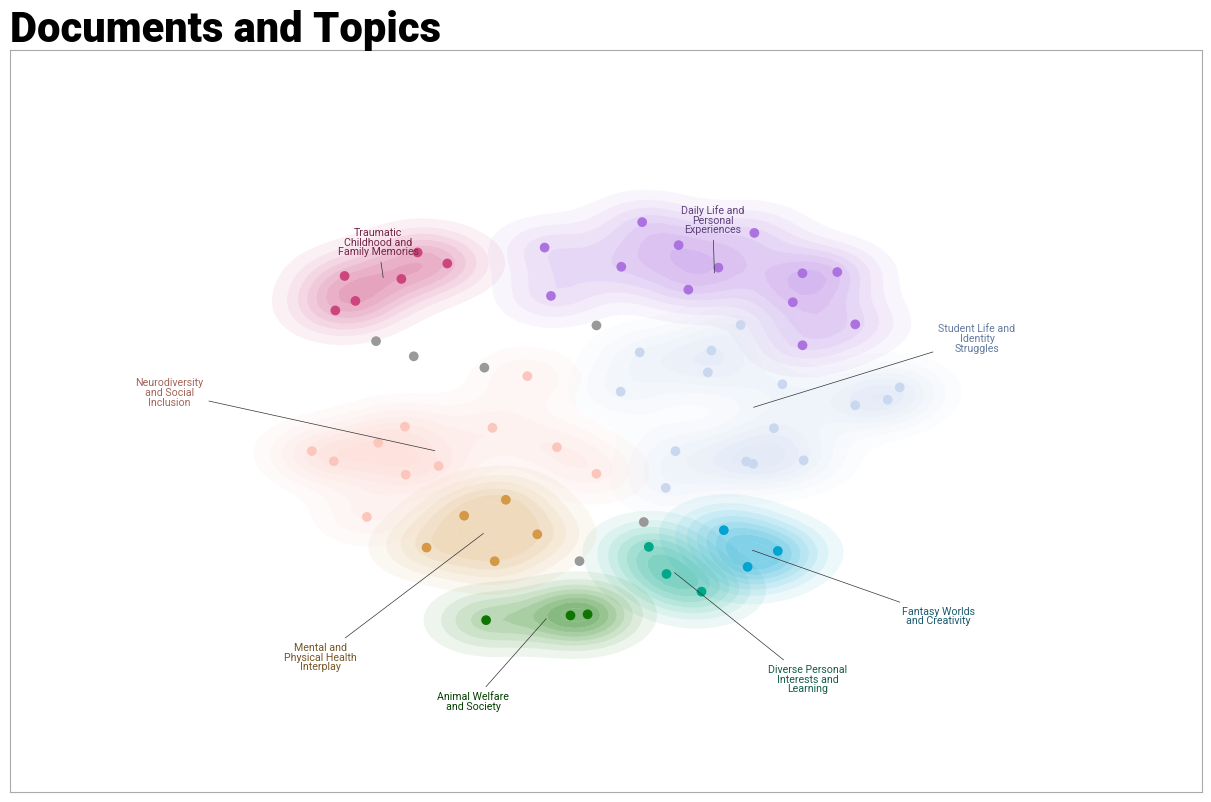

✅ Document datamap created successfully
Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: with you, to do, I started, time, things
Topic 1: day, today, yet, week, why
Topic 2: adhd, people, life, there, where
Topic 3: mother, memory, years, lots of, because
Topic 4: health, interest, in this, accompanied, childish
Topic 5: world, so, I can explain, idea, explain
Topic 6: be, reasons, truly, trend, behavior
Topic 7: areas, all, special interest, special, interest
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5, 6, 7]
DEBUG: Topic 0 -> Label: Student Life and Identity Struggles
DEBUG: Topic 1 -> Label: Daily Life and Personal Experiences
DEBUG: Topic 2 -> Label: Neurodiversity and Social Inclusion
DEBUG: Topic 3 -> Label: Traumatic Childhood and Family Memories
DEBUG: Topic 4 -> Label: Mental and Physical Health Interplay
DEBUG: Topic 5 -> Label: Fantasy Worlds and Creativity
DEBUG: Topic 6 -> Label: Animal Welfare and Society
DEBUG: Topic 


💾 Saving topic texts to individual files...
💾 Saved 3 texts for Topic 5 (Fantasy Worlds and Creativity) to Female_ADHD_topic_5_fantasy_worlds_and_creativity.txt
📝 Skipping outlier topic -1 with 6 texts
💾 Saved 3 texts for Topic 6 (Animal Welfare and Society) to Female_ADHD_topic_6_animal_welfare_and_society.txt
💾 Saved 15 texts for Topic 0 (Student Life and Identity Struggles) to Female_ADHD_topic_0_student_life_and_identity_struggles.txt
💾 Saved 5 texts for Topic 4 (Mental and Physical Health Interplay) to Female_ADHD_topic_4_mental_and_physical_health_interplay.txt
💾 Saved 3 texts for Topic 7 (Diverse Personal Interests and Learning) to Female_ADHD_topic_7_diverse_personal_interests_and_learning.txt
💾 Saved 11 texts for Topic 2 (Neurodiversity and Social Inclusion) to Female_ADHD_topic_2_neurodiversity_and_social_inclusion.txt
💾 Saved 13 texts for Topic 1 (Daily Life and Personal Experiences) to Female_ADHD_topic_1_daily_life_and_personal_experiences.txt
💾 Saved 6 texts for Topic 3 

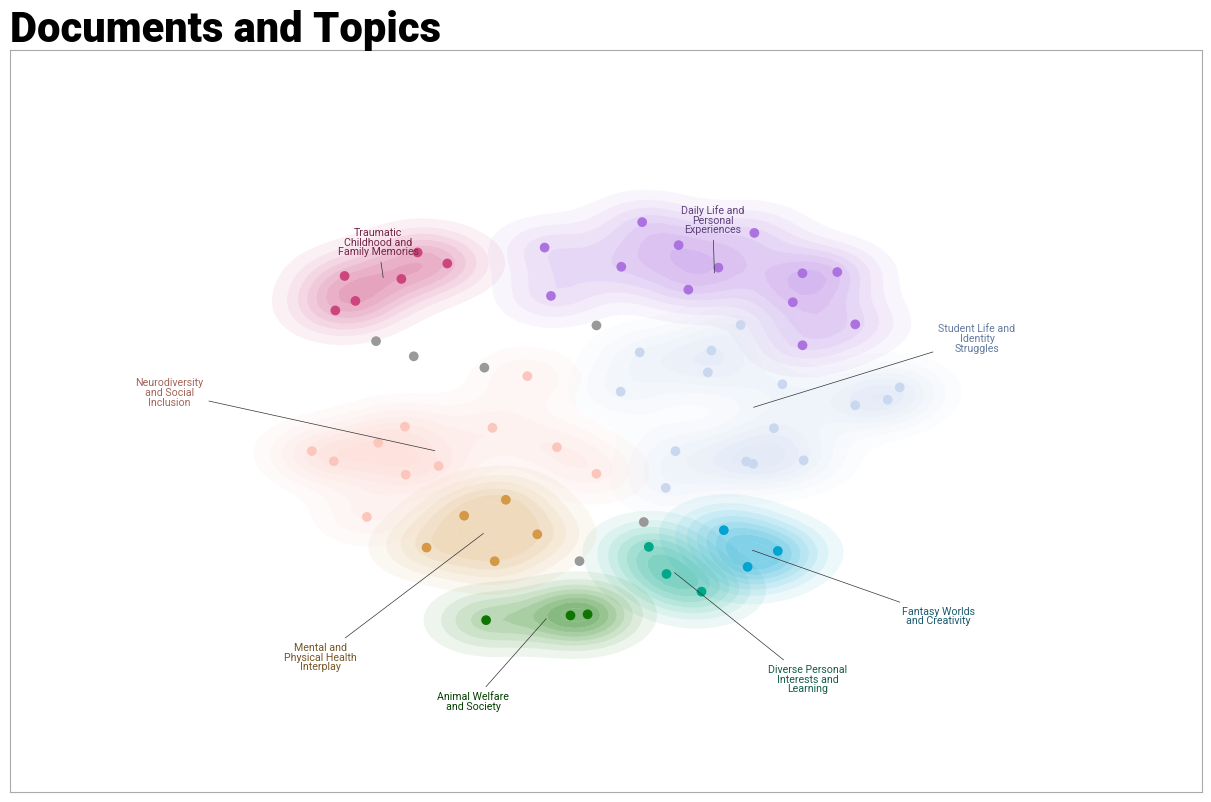

In [21]:
process_group(group_name, folder)

# Female no-ADHD

In [22]:
group_name = "Female_noADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/", name))]
folder = folders[0] if folders else None
folder

'Female_noADHD_3_reduced_15_20250825_012136'

Found folder: Female_noADHD_3_reduced_15_20250825_012136
Running preliminary steps for group: Female_noADHD, folder: Female_noADHD_3_reduced_15_20250825_012136
Female_noADHD
🔄 Generating hierarchical topics...


100%|██████████| 14/14 [00:00<00:00, 508.18it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250829_231834_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250829_231834_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_noADHD/Female_noADHD_3_reduced_15_20250825_012136
------------------------------------------------------------


✅ Hierarchy visualization saved
📊 Number of unique topics: 16
📊 Number of real topics (excluding outliers): 15
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250829_231836_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250829_231836_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_noADHD/Female_noADHD_3_reduced_15_20250825_012136
------------------------------------------------------------


✅ Topic visualization created successfully
📊 SILHOUETTE SCORE DIAGNOSTICS:
  Total documents: 220
  Outlier documents (-1 topic): 37 (16.8%)
  Valid documents: 183 (83.2%)
  Number of unique topics: 15
  Topic distribution: {4: 12, 3: 14, 10: 4, 11: 4, 5: 8, 1: 37, 9: 6, 6: 8, 12: 4, 0: 45, 7: 7, 2: 20, 8: 6, 13: 4, 14: 4}
🔄 Using original embeddings (1536D)...
✅ Silhouette score: 0.0439 (method: Original embeddings (1536D))
📈 Interpretation: Poor clustering (overlapping clusters)
Silhouette Score: 0.0439
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.1313
Individual Topic Coherences:
  Topic 0: -1.3954
  Topic 1: -1.7923
  Topic 2: -1.2193
  Topic 3: -1.0041
  Topic 4: -1.6466
  Topic 5: -0.9211
  Topic 6: -1.1998
  Topic 7: -1.0976
  Topic 8: -1.0856
  Topic 9: -1.1299
  Topic 10: -0.5973
  Topic 11: -0.9723
  Topic 12: -1.2028
  Topic 13: -0.8979
  Topic 14: -0.8071
Coherence results saved to ../../outputs/bertopic_final/F

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Adoro cozinhar, porque sinto que é a forma ide...",4,4_cozinhar_gosto_adoro_acalma,Relaxing Personal Leisure Activities,"[cozinhar, gosto, adoro, acalma, porque, cor, ...","[sentir bem, adoro fazer, gosto nadar, acalma,...",[Relaxing Personal Leisure Activities],"[cozinhar, adoro, acalma, fazer coisas, permit...","[cor, pontos, disposta, desporto, dia, cérebro...",NaN,cozinhar - gosto - adoro - acalma - porque - c...,False
1,Gosto de ver séries porque relatam relações sa...,3,3_ler_história_músicas_livros,Impact of Fiction on Identity,"[ler, história, músicas, livros, forma, intere...","[livros, ler, the, lido, histórias, escrita, r...",[Impact of Fiction on Identity],"[história, músicas, livros, gosto, amor, volta...","[músicas, história, livros, forma, interesse, ...",NaN,ler - história - músicas - livros - forma - in...,False
2,Campos de ferias. Temos que criar o campo todo...,-1,-1_dia_gosto_dias_todos,Outlier Topic,"[dia, gosto, dias, todos, animais, consegui, h...","[fazer, ir, saí, tempo, acordei, fazer exame, ...",[Personal Life and Daily Routines],"[dias, animais, hoje, ainda, jogos, anos, cois...","[dia, gosto, dias, animais, horas, pouco, jogo...",NaN,dia - gosto - dias - todos - animais - consegu...,False
3,"Taylor Swift, amo o seu liricismo e a maneira ...",3,3_ler_história_músicas_livros,Impact of Fiction on Identity,"[ler, história, músicas, livros, forma, intere...","[livros, ler, the, lido, histórias, escrita, r...",[Impact of Fiction on Identity],"[história, músicas, livros, gosto, amor, volta...","[músicas, história, livros, forma, interesse, ...",NaN,ler - história - músicas - livros - forma - in...,False
4,Historia da arte \nÉ só tão interessante. Para...,-1,-1_dia_gosto_dias_todos,Outlier Topic,"[dia, gosto, dias, todos, animais, consegui, h...","[fazer, ir, saí, tempo, acordei, fazer exame, ...",[Personal Life and Daily Routines],"[dias, animais, hoje, ainda, jogos, anos, cois...","[dia, gosto, dias, animais, horas, pouco, jogo...",NaN,dia - gosto - dias - todos - animais - consegu...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
215,A noção de que procuro ser sempre uma boa pess...,1,1_pessoas_sempre_vezes_algo,Personal Reflection and Social Concerns,"[pessoas, sempre, vezes, algo, sinto, perceber...","[muitas vezes, sentir, sinto, vezes, memórias,...",[Personal Reflection and Social Concerns],"[vezes, perceber, cabeça, lembro, escrever, im...","[pessoas, vezes, cabeça, atenção, dia, mesma, ...",NaN,pessoas - sempre - vezes - algo - sinto - perc...,False
216,—,10,10_biblioteca_escrita_pessoas_,Language and Human Communication,"[biblioteca, escrita, pessoas, , , , , , , ]","[escrita, , , , , , , , , ]",[Language and Human Communication],"[biblioteca, escrita, pessoas, , , , , , , , ,...","[biblioteca, escrita, pessoas, , , , , , , ]",NaN,biblioteca - escrita - pessoas - - - - - ...,False
217,As vezes aborrece-me ter de escrever/responder...,-1,-1_dia_gosto_dias_todos,Outlier Topic,"[dia, gosto, dias, todos, animais, consegui, h...","[fazer, ir, saí, tempo, acordei, fazer exame, ...",[Personal Life and Daily Routines],"[dias, animais, hoje, ainda, jogos, anos, cois...","[dia, gosto, dias, animais, horas, pouco, jogo...",NaN,dia - gosto - dias - todos - animais - consegu...,False
218,Maiores dificuldades que sempre senti.. Concen...,1,1_pessoas_sempre_vezes_algo,Personal Reflection and Social Concerns,"[pessoas, sempre, vezes, algo, sinto, perceber...","[muitas vezes, sentir, sinto, vezes, memórias,...",[Personal Reflection and Social Concerns],"[vezes, perceber, cabeça, lembro, escrever, im...","[pessoas, vezes, cabeça, atenção, dia, mesma, ...",NaN,pessoas - sempre - vezes - algo - sinto - perc...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250829_231837_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250829_231837_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_noADHD/Female_noADHD_3_reduced_15_20250825_012136
------------------------------------------------------------


4it [00:00, 130.23it/s]

🔍 DEBUG: Analyzing figure structure for class separators...
🔍 Extracting y-values from trace data...
📋 Extracted y-categories from traces: ['Diary Entry', 'Empty Sheet', 'Self-Defining Memory', 'Special Interest']
🔧 Adding dashed separators for 4 categories...
  Boundary between 'Diary Entry' and 'Empty Sheet' at position 0.5
  Boundary between 'Empty Sheet' and 'Self-Defining Memory' at position 1.5
  Boundary between 'Self-Defining Memory' and 'Special Interest' at position 2.5
✅ Added 3 dashed separators between classes
✅ Successfully customized topics per class figure with dashed separators
🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250829_231839_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250829_231839_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_noADHD/Female_noADHD_3_reduced_15_20250825_012136
------------------------------------------------------------


🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250829_231843_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250829_231843_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/Female_noADHD/Female_noADHD_3_reduced_15_20250825_012136
------------------------------------------------------------


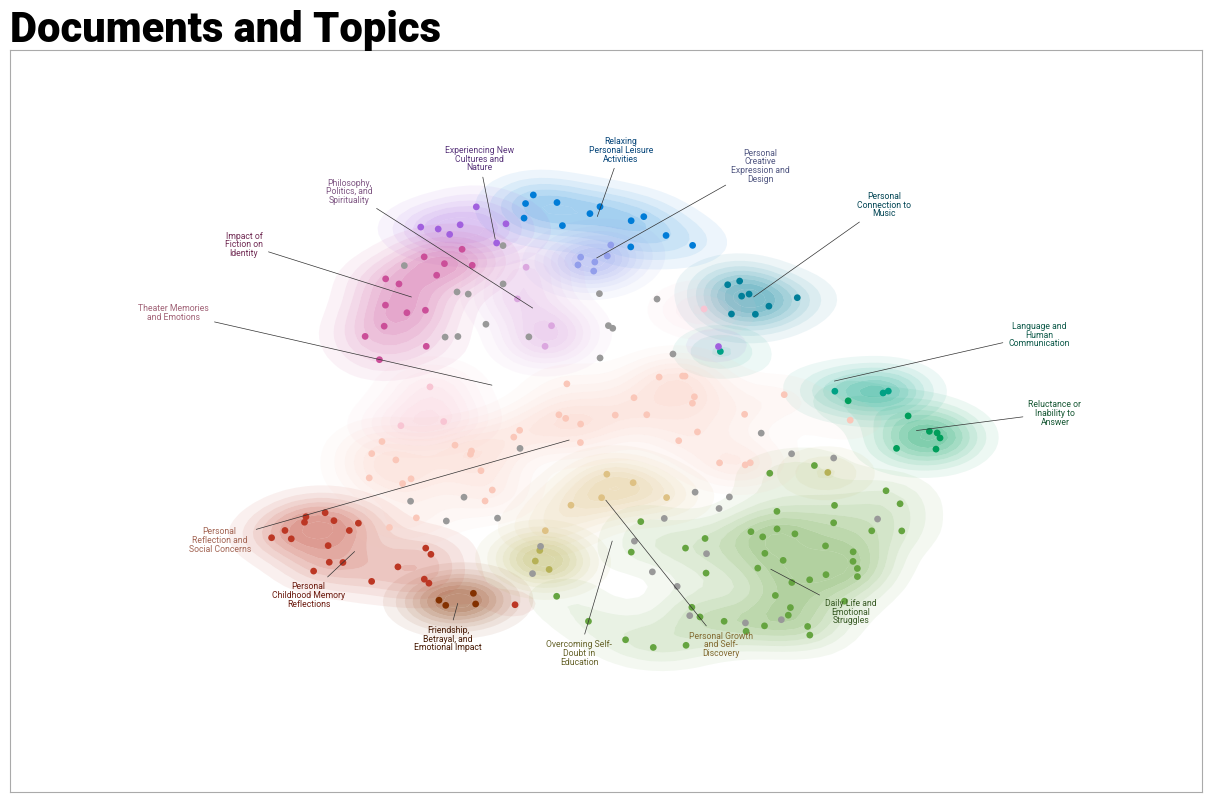

✅ Document datamap created successfully
Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: day, today, to do, why, work
Topic 1: people, always, times, something, I feel
Topic 2: memory, I remember, years, mother, to say
Topic 3: to read, history, songs, books, shape
Topic 4: to cook, I like, I adore, calm, why
Topic 5: music, to hear, touch, while, both
Topic 6: travel, new, to feel, silence, world
Topic 7: to respond, I prefer, none, occur, question
Topic 8: path, English, he did, liked, confusion
Topic 9: use, I like, environment, art, huge
Topic 10: library, writing, people, , 
Topic 11: teacher, photographs, to do, to cry, never
Topic 12: policy, I like, life, I find it interesting, population
Topic 13: able, exam, capabilities, get, me
Topic 14: friend, to speak, I wanted, message, group
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
DEBUG: Topic 0 -> Label: Daily Life and Emotional Struggles
DEBUG: Topic 1 -> Label: Pe


💾 Saving topic texts to individual files...
💾 Saved 12 texts for Topic 4 (Relaxing Personal Leisure Activities) to Female_noADHD_topic_4_relaxing_personal_leisure_activities.txt
💾 Saved 14 texts for Topic 3 (Impact of Fiction on Identity) to Female_noADHD_topic_3_impact_of_fiction_on_identity.txt
📝 Skipping outlier topic -1 with 37 texts
💾 Saved 4 texts for Topic 10 (Language and Human Communication) to Female_noADHD_topic_10_language_and_human_communication.txt
💾 Saved 4 texts for Topic 11 (Theater Memories and Emotions) to Female_noADHD_topic_11_theater_memories_and_emotions.txt
💾 Saved 8 texts for Topic 5 (Personal Connection to Music) to Female_noADHD_topic_5_personal_connection_to_music.txt
💾 Saved 37 texts for Topic 1 (Personal Reflection and Social Concerns) to Female_noADHD_topic_1_personal_reflection_and_social_concerns.txt
💾 Saved 6 texts for Topic 9 (Personal Creative Expression and Design) to Female_noADHD_topic_9_personal_creative_expression_and_design.txt
💾 Saved 8 texts

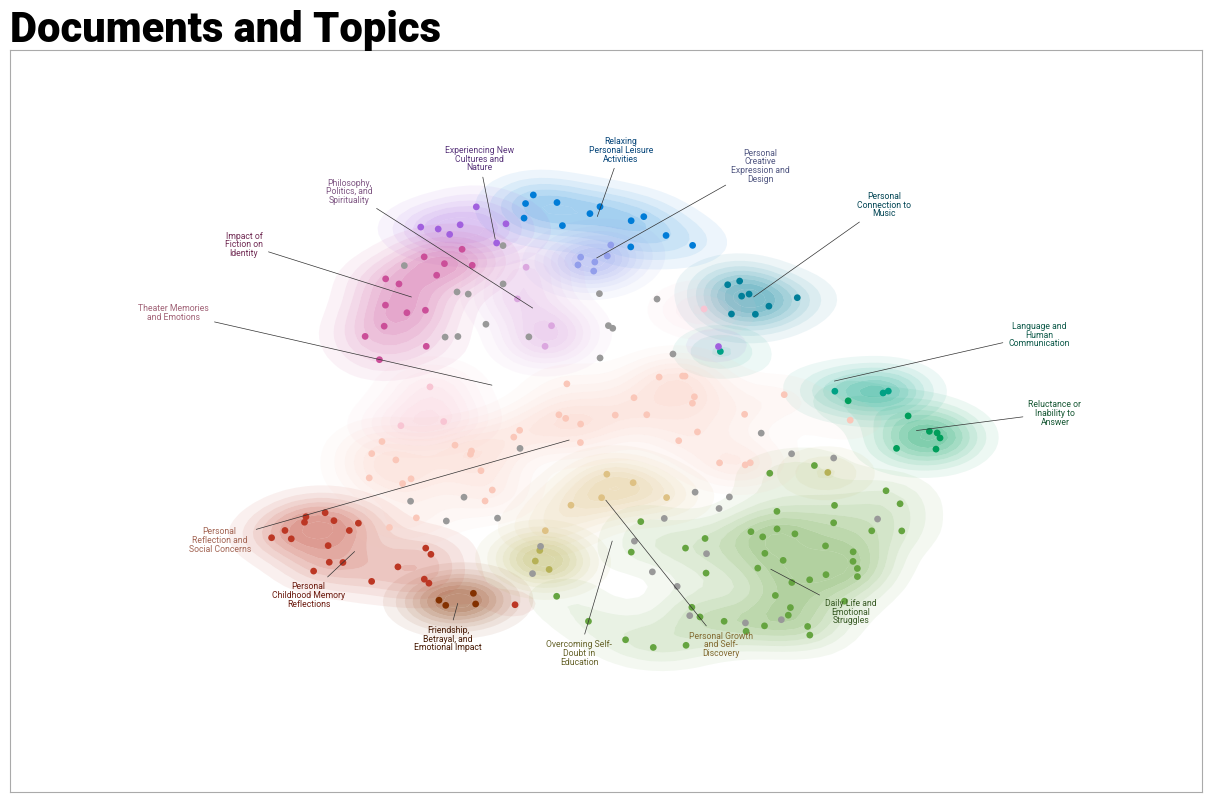

In [23]:
process_group(group_name, folder)

# ADHD

In [24]:
group_name = "ADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/", name))]
folder = folders[0] if folders else None
folder

'ADHD_2_13_20250824_214730'

Found folder: ADHD_2_13_20250824_214730
Running preliminary steps for group: ADHD, folder: ADHD_2_13_20250824_214730
ADHD
🔄 Generating hierarchical topics...


100%|██████████| 12/12 [00:00<00:00, 590.83it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...


🖼️  Saved bertopic_hierarchy_ADHD as PNG: 20250829_231924_bertopic_hierarchy_adhd.png
📊 Saved bertopic_hierarchy_ADHD as HTML: 20250829_231924_bertopic_hierarchy_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/ADHD/ADHD_2_13_20250824_214730
------------------------------------------------------------


✅ Hierarchy visualization saved
📊 Number of unique topics: 14
📊 Number of real topics (excluding outliers): 13
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_ADHD as PNG: 20250829_231926_bertopic_topics_adhd.png
📊 Saved bertopic_topics_ADHD as HTML: 20250829_231926_bertopic_topics_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/ADHD/ADHD_2_13_20250824_214730
------------------------------------------------------------


✅ Topic visualization created successfully
📊 SILHOUETTE SCORE DIAGNOSTICS:
  Total documents: 94
  Outlier documents (-1 topic): 11 (11.7%)
  Valid documents: 83 (88.3%)
  Number of unique topics: 13
  Topic distribution: {8: 4, 7: 5, 6: 5, 4: 6, 9: 4, 11: 3, 10: 4, 5: 5, 3: 7, 0: 16, 1: 13, 2: 9, 12: 2}
🔄 Using original embeddings (1536D)...
✅ Silhouette score: 0.0434 (method: Original embeddings (1536D))
📈 Interpretation: Poor clustering (overlapping clusters)
Silhouette Score: 0.0434
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -0.9028
Individual Topic Coherences:
  Topic 0: -0.7631
  Topic 1: -1.3045
  Topic 2: -1.2630
  Topic 3: -1.0166
  Topic 4: -0.9704
  Topic 5: -1.0846
  Topic 6: -0.8906
  Topic 7: -0.5479
  Topic 8: -0.8053
  Topic 9: -0.3136
  Topic 10: -0.7920
  Topic 11: -0.5984
  Topic 12: -1.3867
Coherence results saved to ../../outputs/bertopic_final/ADHD/ADHD_2_13_20250824_214730/
Number of texts: 94
Number o

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Não estudo no sentido literal, mas interesso-m...",8,8_geral_estudo_saúde_mental,Human Psychology and Wellbeing,"[geral, estudo, saúde, mental, humana, cuidar,...","[psicologia, saúde mental, mental, pensamentos...",[Human Psychology and Wellbeing],"[geral, estudo, saúde, cuidar, psicologia, exi...","[geral, estudo, saúde, mental, ações, existênc...",NaN,geral - estudo - saúde - mental - humana - cui...,False
1,Linux!,-1,-1_mim_amigos_passei_vezes,Outlier Topic,"[mim, amigos, passei, vezes, dia, todos, manei...","[mim, depressão, comigo mesma, sinto, passei, ...","[Identity, Belonging, Social Exclusion]","[mim, amigos, passei, vezes, dia, nunca, nesse...","[amigos, vezes, dia, maneira, comigo, vida, mi...",NaN,mim - amigos - passei - vezes - dia - todos - ...,False
2,Gosto muito de arrumação gosto de ter tudo arr...,7,7_gosto_zonas_normalmente_focada,Activities for Relaxation and Focus,"[gosto, zonas, normalmente, focada, usar, enco...","[stressar, correr, usar, consigo, tempo, busca...",[Activities for Relaxation and Focus],"[zonas, normalmente, focada, encontrar, stress...","[zonas, procura, focada, rápido, momento, temp...",NaN,gosto - zonas - normalmente - focada - usar - ...,False
3,"Gosto imenso de montanhas russas, às vezes gos...",6,6_apresentação_gosto_fez_primeira,"Thrill, Adrenaline, and Self-Discovery","[apresentação, gosto, fez, primeira, menos, cé...","[memórias, altos baixos, mim, apeteceu, situaç...","[Thrill, Adrenaline, and Self-Discovery]","[apresentação, primeira, jogo, vezes, vida, al...","[apresentação, gosto, primeira, menos, cérebro...",NaN,apresentação - gosto - fez - primeira - menos ...,False
4,"Pedras, necrópoles, minerais, música, cinema, ...",4,4_tão_áreas_mundo_apenas,Human Creativity and Complex Interests,"[tão, áreas, mundo, apenas, interesse especial...","[fascinante, interesse especial, criar, compos...",[Human Creativity and Complex Interests],"[mundo, interesse especial, própria, pergunta ...","[áreas, mundo, especial, interesse, mente, fas...",NaN,tão - áreas - mundo - apenas - interesse espec...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
89,"""O serial killer e o bode espiatorio"". O pânic...",3,3_phda_lá_continua_diagnóstico,ADHD Diagnosis and Daily Challenges,"[phda, lá, continua, diagnóstico, medicação, p...","[psiquiatra, diagnóstico, pânico, depressão, p...",[ADHD Diagnosis and Daily Challenges],"[phda, diagnóstico, medicação, continuam, atua...","[phda, medicação, diagnóstico, pessoas, segund...",NaN,phda - lá - continua - diagnóstico - medicação...,False
90,"O ponto em que sociedade se está a tornar,: eg...",-1,-1_mim_amigos_passei_vezes,Outlier Topic,"[mim, amigos, passei, vezes, dia, todos, manei...","[mim, depressão, comigo mesma, sinto, passei, ...","[Identity, Belonging, Social Exclusion]","[mim, amigos, passei, vezes, dia, nunca, nesse...","[amigos, vezes, dia, maneira, comigo, vida, mi...",NaN,mim - amigos - passei - vezes - dia - todos - ...,False
91,Gostava que não dissessem : toda a gente tem p...,3,3_phda_lá_continua_diagnóstico,ADHD Diagnosis and Daily Challenges,"[phda, lá, continua, diagnóstico, medicação, p...","[psiquiatra, diagnóstico, pânico, depressão, p...",[ADHD Diagnosis and Daily Challenges],"[phda, diagnóstico, medicação, continuam, atua...","[phda, medicação, diagnóstico, pessoas, segund...",NaN,phda - lá - continua - diagnóstico - medicação...,False
92,Não sei explicar o que se anda a passar comigo...,12,12_falar_pessoa_pessoas_vida,Self-Esteem and Social Anxiety,"[falar, pessoa, pessoas, vida, comigo, aborrec...","[medo, aborrecimento, comigo própria, comigo, ...",[Self-Esteem and Social Anxiety],"[falar, aborrecimento, comigo própria, confian...","[pessoa, pessoas, vida, aborrecimento, vergonh...",NaN,falar - pessoa - pessoas - vida - comigo - abo...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_ADHD as PNG: 20250829_231927_bertopic_heatmap_adhd.png
📊 Saved bertopic_heatmap_ADHD as HTML: 20250829_231927_bertopic_heatmap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/ADHD/ADHD_2_13_20250824_214730
------------------------------------------------------------


4it [00:00, 148.17it/s]

🔍 DEBUG: Analyzing figure structure for class separators...
🔍 Extracting y-values from trace data...
📋 Extracted y-categories from traces: ['Diary Entry', 'Empty Sheet', 'Self-Defining Memory', 'Special Interest']
🔧 Adding dashed separators for 4 categories...
  Boundary between 'Diary Entry' and 'Empty Sheet' at position 0.5
  Boundary between 'Empty Sheet' and 'Self-Defining Memory' at position 1.5
  Boundary between 'Self-Defining Memory' and 'Special Interest' at position 2.5
✅ Added 3 dashed separators between classes
✅ Successfully customized topics per class figure with dashed separators
🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_ADHD as PNG: 20250829_231929_bertopic_topics_per_class_adhd.png
📊 Saved bertopic_topics_per_class_ADHD as HTML: 20250829_231929_bertopic_topics_per_class_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/ADHD/ADHD_2_13_20250824_214730
------------------------------------------------------------


🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_ADHD as PNG: 20250829_231932_bertopic_document_datamap_adhd.png
📊 Saved bertopic_document_datamap_ADHD as HTML: 20250829_231932_bertopic_document_datamap_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/ADHD/ADHD_2_13_20250824_214730
------------------------------------------------------------


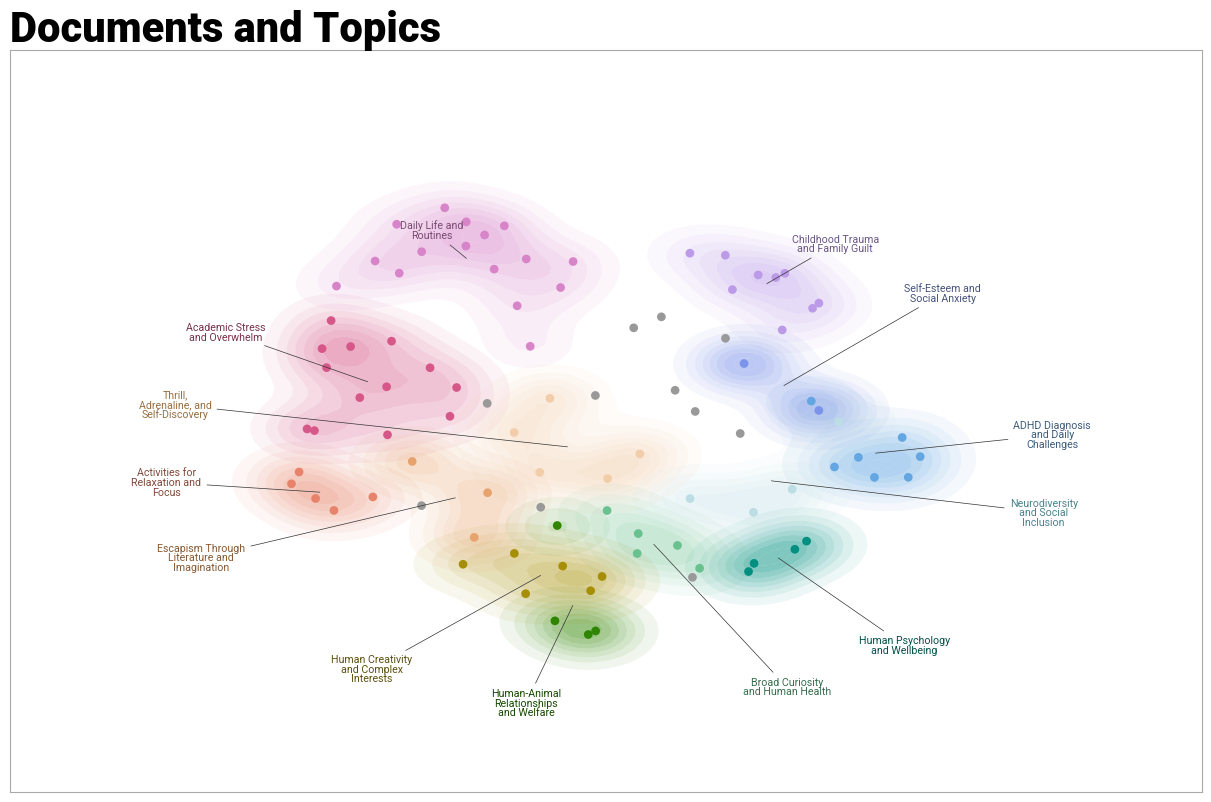

✅ Document datamap created successfully
Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: week, today, I woke up, to work, day
Topic 1: to do, nothing, I feel, with you, time
Topic 2: mother, years, marked, father, yet
Topic 3: adhd, there, continues, diagnosis, medication
Topic 4: so, areas, world, just, special interest
Topic 5: all, interest, special interests, body, nothing
Topic 6: presentation, I like, he did, first, less
Topic 7: I like, zones, normally, focused, to use
Topic 8: general, study, health, mental, human
Topic 9: animal, be, game, trend, reasons
Topic 10: always, ADHD, normal, none, autism
Topic 11: to read, day day, fascinating, willing, new
Topic 12: to speak, person, people, life, with me
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
DEBUG: Topic 0 -> Label: Daily Life and Routines
DEBUG: Topic 1 -> Label: Academic Stress and Overwhelm
DEBUG: Topic 2 -> Label: Childhood Trauma and Family Guilt
DEBUG: T


💾 Saving topic texts to individual files...
💾 Saved 4 texts for Topic 8 (Human Psychology and Wellbeing) to ADHD_topic_8_human_psychology_and_wellbeing.txt
📝 Skipping outlier topic -1 with 11 texts
💾 Saved 5 texts for Topic 7 (Activities for Relaxation and Focus) to ADHD_topic_7_activities_for_relaxation_and_focus.txt
💾 Saved 5 texts for Topic 6 (Thrill, Adrenaline, and Self-Discovery) to ADHD_topic_6_thrill_adrenaline_and_self-discovery.txt
💾 Saved 6 texts for Topic 4 (Human Creativity and Complex Interests) to ADHD_topic_4_human_creativity_and_complex_interests.txt
💾 Saved 4 texts for Topic 9 (Human-Animal Relationships and Welfare) to ADHD_topic_9_human-animal_relationships_and_welfare.txt
💾 Saved 3 texts for Topic 11 (Escapism Through Literature and Imagination) to ADHD_topic_11_escapism_through_literature_and_imagination.txt
💾 Saved 4 texts for Topic 10 (Neurodiversity and Social Inclusion) to ADHD_topic_10_neurodiversity_and_social_inclusion.txt
💾 Saved 5 texts for Topic 5 (Broa

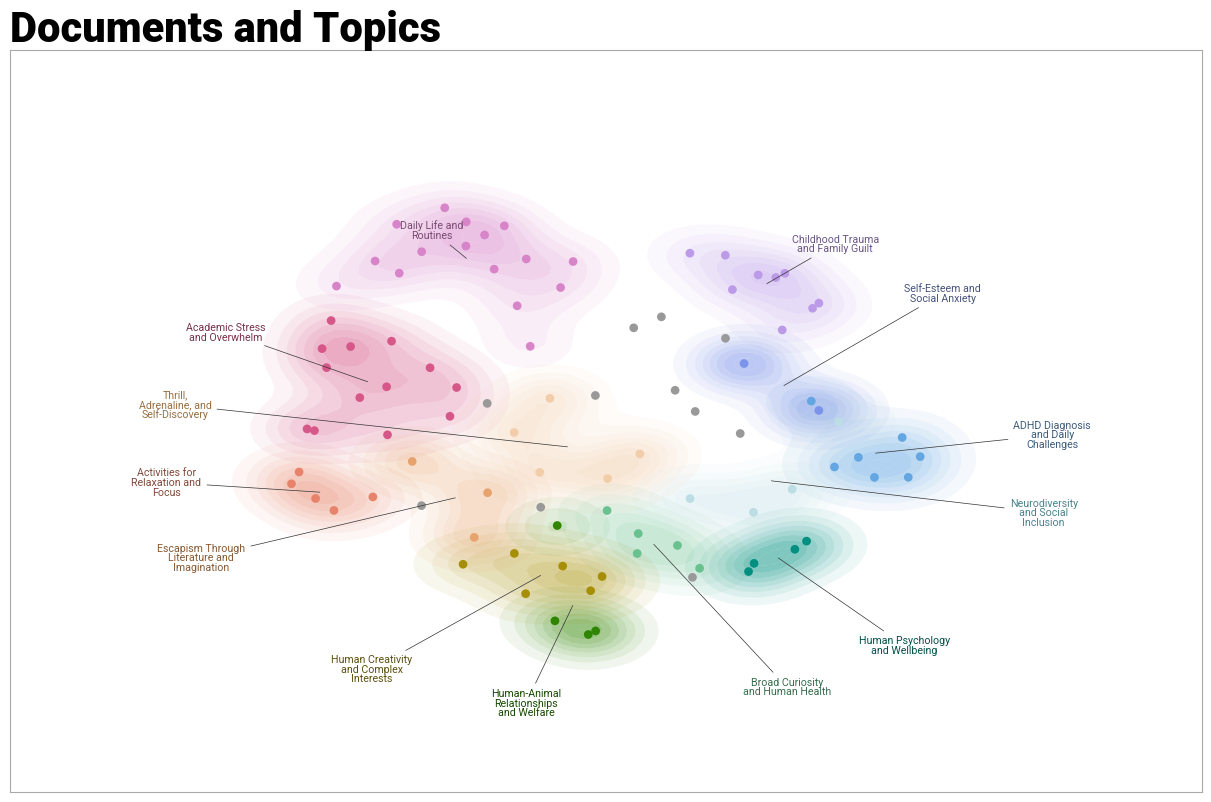

In [25]:
process_group(group_name, folder)

# no-ADHD

In [20]:
group_name = "noADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_final/{group_name}/", name))]
folder = folders[0] if folders else None
folder

'noADHD_3_reduced_26_20250825_015611'

In [ ]:
process_group(group_name, folder)

Found folder: noADHD_3_reduced_26_20250825_015611
Running preliminary steps for group: noADHD, folder: noADHD_3_reduced_26_20250825_015611
noADHD
🔄 Generating hierarchical topics...


100%|██████████| 25/25 [00:00<00:00, 604.22it/s]

✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250830_190257_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250830_190257_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/noADHD/noADHD_3_reduced_26_20250825_015611
------------------------------------------------------------


✅ Hierarchy visualization saved
📊 Number of unique topics: 27
📊 Number of real topics (excluding outliers): 26
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250830_190306_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250830_190306_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/noADHD/noADHD_3_reduced_26_20250825_015611
------------------------------------------------------------


✅ Topic visualization created successfully
📊 SILHOUETTE SCORE DIAGNOSTICS:
  Total documents: 353
  Outlier documents (-1 topic): 48 (13.6%)
  Valid documents: 305 (86.4%)
  Number of unique topics: 26
  Topic distribution: {10: 7, 17: 5, 0: 68, 13: 6, 6: 12, 1: 28, 5: 15, 9: 11, 23: 4, 11: 7, 24: 4, 12: 7, 20: 5, 7: 12, 16: 6, 21: 5, 3: 20, 25: 4, 4: 15, 19: 5, 18: 5, 8: 11, 22: 5, 2: 26, 15: 6, 14: 6}
🔄 Using original embeddings (1536D)...
✅ Silhouette score: 0.0559 (method: Original embeddings (1536D))
📈 Interpretation: Poor clustering (overlapping clusters)
Silhouette Score: 0.0559
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.1804
Individual Topic Coherences:
  Topic 0: -1.0623
  Topic 1: -1.4406
  Topic 2: -1.5344
  Topic 3: -1.6629
  Topic 4: -1.3413
  Topic 5: -0.8614
  Topic 6: -1.1233
  Topic 7: -1.6225
  Topic 8: -1.2505
  Topic 9: -1.0918
  Topic 10: -1.4779
  Topic 11: -1.4701
  Topic 12: -1.4390
  Topic 13: -1.

,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Adoro cozinhar, porque sinto que é a forma ide...",10,10_gosto_cozinhar_adoro_felizes,Personal Joys and Pleasures,"[gosto, cozinhar, adoro, felizes, favoritas, v...","[cozinhar, porque gosto, doces, gosto ver, com...",[Personal Joys and Pleasures],"[gosto, cozinhar, felizes, favoritas, visitar,...","[gosto, favoritas, felizes, anos, uso, saudade...",NaN,gosto - cozinhar - adoro - felizes - favoritas...,False
1,Gosto de ver séries porque relatam relações sa...,17,17_historia_forma_algum tipo_saudáveis,Emotional Impact of Visual Storytelling,"[historia, forma, algum tipo, saudáveis, histó...","[ver séries, séries, filme, cinema, histórias,...",[Emotional Impact of Visual Storytelling],"[saudáveis, histórias, ver séries, vida real, ...","[historia, forma, saudáveis, histórias, cinema...",NaN,historia - forma - algum tipo - saudáveis - hi...,False
2,Campos de ferias. Temos que criar o campo todo...,0,0_dia_tarde_trabalho_tempo,Daily Routines and Emotional Challenges,"[dia, tarde, trabalho, tempo, casa, acordei, f...","[hoje acordei, acordei, comecei, dormi, fiquei...",[Daily Routines and Emotional Challenges],"[tarde, tempo, acordei, trabalhar, dormir, fiq...","[dia, tarde, trabalho, tempo, casa, manhã, pai...",NaN,dia - tarde - trabalho - tempo - casa - acorde...,False
3,"Taylor Swift, amo o seu liricismo e a maneira ...",13,13_história_anime_animais_interesse especial,Immersive Fantasy and Anime Interests,"[história, anime, animais, interesse especial,...","[anime, fantasia, gostar tanto, social gosto, ...",[Immersive Fantasy and Animal Interests],"[história, anime, personagens, hoje continuo, ...","[história, anime, animais, interesse, especial...",NaN,história - anime - animais - interesse especia...,False
4,Historia da arte \nÉ só tão interessante. Para...,6,6_políticas_física_interessante_política,Political and Scientific Perspectives,"[políticas, física, interessante, política, te...","[políticas, politica, política, entender, prob...",[Political and Scientific Perspectives],"[políticas, física, entender, alterar, difícei...","[políticas, física, interessante, política, te...",NaN,políticas - física - interessante - política -...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
348,A noção de que procuro ser sempre uma boa pess...,-1,-1_dia_algo_sempre_jogo,Daily Life and Personal Challenges,"[dia, algo, sempre, jogo, hoje, tudo, passar, ...","[senti, sinto, sair, cansativo, mim, ir, últim...",[Daily Life and Personal Challenges],"[hoje, passar, fazer, mim, tentar, pensamentos...","[dia, jogo, pensamentos, exemplo, mesma, meses...",NaN,dia - algo - sempre - jogo - hoje - tudo - pas...,False
349,—,23,23_dias semana_base_data_escrita,Days of the Week Calculation,"[dias semana, base, data, escrita, semana, dia...","[escrita, data, base, , , , , , , ]",[Days of the Week Calculation],"[dias semana, base, data, escrita, semana, dia...","[base, data, escrita, semana, dias, , , , , ]",NaN,dias semana - base - data - escrita - semana -...,False
350,As vezes aborrece-me ter de escrever/responder...,14,14_questionário_parece_escrever_aqui,Procrastination and Writing Struggles,"[questionário, parece, escrever, aqui, chegou,...","[escrever, muitas vezes, dificuldades, fazer, ...",[Procrastination and Writing Struggles],"[questionário, escrever, vezes, dia acaba, def...","[questionário, autocarro, vezes, tabs, própria...",NaN,questionário - parece - escrever - aqui - cheg...,False
351,Maiores dificuldades que sempre senti.. Concen...,-1,-1_dia_algo_sempre_jogo,Daily Life and Personal Challenges,"[dia, algo, sempre, jogo, hoje, tudo, passar, ...","[senti, sinto, sair, cansativo, mim, ir, últim...",[Daily Life and Personal Challenges],"[hoje, passar, fazer, mim, tentar, pensamentos...","[dia, jogo, pensamentos, exemplo, mesma, meses...",NaN,dia - algo - sempre - jogo - hoje - tudo - pas...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250830_190307_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250830_190307_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/noADHD/noADHD_3_reduced_26_20250825_015611
------------------------------------------------------------


4it [00:00, 93.53it/s]

🔍 DEBUG: Analyzing figure structure for class separators...
🔍 Extracting y-values from trace data...
📋 Extracted y-categories from traces: ['Diary Entry', 'Empty Sheet', 'Self-Defining Memory', 'Special Interest']
🔧 Adding dashed separators for 4 categories...
  Boundary between 'Diary Entry' and 'Empty Sheet' at position 0.5
  Boundary between 'Empty Sheet' and 'Self-Defining Memory' at position 1.5
  Boundary between 'Self-Defining Memory' and 'Special Interest' at position 2.5
✅ Added 3 dashed separators between classes
✅ Successfully customized topics per class figure with dashed separators
🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250830_190309_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250830_190309_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_final/noADHD/noADHD_3_reduced_26_20250825_015611
------------------------------------------------------------


🔄 Creating document datamap...
